In [1]:
import tensorflow as tf
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt

from strawberryfields import ops

from qmlt.tf import CircuitLearner
from qmlt.tf.helpers import make_param

from sklearn.utils import shuffle
from sklearn.datasets import load_digits

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or 

In [2]:
tf.set_random_seed(0)

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9371689580581794269
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10943050548
locality {
  bus_id: 1
}
incarnation: 8724876518518470941
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


### Preparing dataset

We install a data from 

In [4]:
 def make_matrixes_4x4(x, axs_scale):  # TODO

        """
            идем матрицей 3х3 с шагом 1,
            тогда из мтарицы 8х8 получаем 6х6
        """
        output = []
        for i in range(0, axs_scale-2, 2):  # x
            for j in range(0, axs_scale-2, 2):  # y
                matrix = [x[i][j], x[i][j + 1], x[i][j + 2], x[i][j + 3],
                         x[i + 1][j], x[i + 1][j + 1], x[i + 1][j + 2], x[i + 1][j + 3],
                         x[i + 2][j], x[i + 2][j + 1], x[i + 2][j + 2], x[i + 2][j + 3],
                         x[i + 3][j], x[i + 3][j + 1], x[i + 3][j + 2], x[i + 3][j + 3]]
                
                output.append(matrix) 
        return output

**code to visualize samples from the dataset**

In [5]:
def draw_samples(samples, samples_number: int) -> None:
    """
    Visualize an ordered amount of randomly chosen samples from a given dataset.
    :param dataset: A Dataset from which to take samples to visualize
    :param samples_number: A number of samples to visualize
    """

    if samples_number % 4 == 0:
        rows = samples_number//4
    else:
        rows = samples_number // 4 + 1

    if samples_number > 4:
        fig, axs = plt.subplots(nrows=rows, ncols=4)
        for i in range(samples_number):
            index = np.random.randint(len(samples))
            # print(index)
            # print(dataset.trainX.shape)
            axs[i // 4, i % 4].imshow(samples[index].reshape([8, 8]))
    else:
        fig, axs = plt.subplots(nrows=rows, ncols=4)
        for i in range(samples_number):
            index = np.random.randint(len(samples))
            # print(dataset.trainX[index].shape)
            axs[i % 4].imshow(samples[index].reshape([8, 8]))
            
    plt.show()

#     plt.savefig('Mnist/CNN/Digits.png')

In [6]:
def create_dataset(split=0.1):
    digits = load_digits()
    
    x = np.array(digits.data) / 255.0
    y = np.array(digits.target)
    
    x, y = shuffle(x, y, random_state=7)

    sep = round(len(x)*split)

    train_x, train_y = x[sep:], y[sep:]
    test_x, test_y = x[:sep], y[:sep]
    
    draw_samples(test_x, 8)

    return train_x, train_y, test_x, test_y

In [7]:
def create_dataset_binary(class0: int, class1=None, split=0.1):
    # загружаем датасет
    digits = load_digits()

    x = np.array(digits.data) / 255.0
    y = np.array(digits.target)

    x0, y0 = x[y == class0], y[y == class0]
    y0 = np.zeros(len(y0))

    if class1 is not None:
        x1, y1 = x[y == class1], y[y == class1]
        y1 = np.ones(len(y1))
    else:
        x1, y1 = x[y != class0], y[y != class0]
        y1 = np.zeros(len(y1))

    x, y = np.vstack((x0, x1)), np.hstack([y0, y1])
    x, y = shuffle(x, y, random_state=7)

    sep = round(len(y) * split)  # default ~10% for a test

    train_x, train_y = x[sep:], y[sep:]
    test_x, test_y = x[:sep], y[:sep]
    
    draw_samples(test_x, 8)

    return train_x, train_y, test_x, test_y

## Quantum Neural Network Model

In [21]:
wires = 8
params_num = 36 + 34


def myloss(circuit_output, targets):
    return tf.losses.mean_squared_error(labels=circuit_output, predictions=targets)


def outputs_to_predictions(outpt):
    return tf.round(outpt)

def circuit(X):

#     params = [make_param(name='phi'+str(i), constant=.5, monitor=True, regularize=False) for i in range(20)]

    def shaper(x):
        """
        x - a single picture
        :param x: an array of pixels
        :return: shape and reshaped array of pixels
        """
        print(x)

        if x.shape[0] == 64:
            return 8, tf.reshape(x, [8, 8])
        elif x.shape[0] == 36:
            return 6, tf.reshape(x, [6, 6])
        elif x.shape[0] == 35:
            return 5, tf.reshape(x, [5, 5])
        elif x.shape[0] == 16:
            return 4, tf.reshape(x, [4, 4])
        elif x.shape[0] == 9:
            return 3, tf.reshape(x, [3, 3])
        elif x.shape[0] == 4:
            return 2, tf.reshape(x, [2, 2])

    def conv_4x4_layer(x, params):
        """
        54 parameters
        :param x: input data with shape (4,)
        :param delta: parameters shift for the current layer
        :return: bosons amount in the 0's qumode.
        """
        
        eng, q = sf.Engine(4)
        
        quater_pi = tf.constant(np.pi / 4, dtype=tf.double)
        
        def layer(delta):
            ops.BSgate(quater_pi, 0.0) | (q[0], q[1])
            ops.BSgate(quater_pi, 0.0) | (q[2], q[3])
#             ops.BSgate(quater_pi, 0) | (q[4], q[5])
#             ops.BSgate(quater_pi, 0) | (q[6], q[7])
            ops.Rgate(params[0 + delta]) | q[0]
            ops.Rgate(params[1 + delta]) | q[1]
            ops.Rgate(params[2 + delta]) | q[2]
            ops.Rgate(params[3 + delta]) | q[3]
            ops.BSgate(quater_pi, 0.0) | (q[1], q[2])
            ops.BSgate(quater_pi, 0.0) | (q[0], q[3])
            ops.Rgate(params[4 + delta]) | q[0]
            ops.Rgate(params[5 + delta]) | q[1]
            ops.Rgate(params[6 + delta]) | q[2]
            ops.Rgate(params[7 + delta]) | q[3]
            ops.Dgate(params[8 + delta]) | q[0]
            ops.Dgate(params[9 + delta]) | q[1]
            ops.Pgate(params[10 + delta]) | q[2]
            ops.Pgate(params[11 + delta]) | q[3]

        with eng:
            for j in range(4):
                ops.Sgate(1.5, x[:, j]) | q[j]
                
            layer(0)
            
            for j in range(4):
#                 ops.Sgate(1.5, x[:, j+4]) | q[j]
                ops.Rgate(np.pi / 4 * x[:, j+4]) | q[j]
            
            layer(12)
            
            for j in range(4):
#                 ops.Sgate(1.5, x[:, j+8]) | q[j]
                ops.Rgate(np.pi / 4 * x[:, j+8]) | q[j]
            
            layer(24)
            
            for j in range(4):
#                 ops.Sgate(1.5, x[:, j+12]) | q[j]
                ops.Rgate(np.pi / 4 * x[:, j+12]) | q[j]
            
            layer(36)

        num_inputs = x.get_shape().as_list()[0]
        state = eng.run('tf', cutoff_dim=7, eval=False, batch_size=num_inputs)
        
        modes = 4*[0]
        modes[0] = 2
        p0 = state.fock_prob(modes)
        modes[0] = 0
        modes[1] = 2
        p1 = state.fock_prob(modes)

        normalization = p0 + p1 + 1e-10  # + p2
        output = p0 / normalization
        return tf.cast(output, dtype=tf.float64)


    def full_con_layer(x, delta, params):

        eng, q = sf.Engine(3)
        
        quater_pi = tf.constant(np.pi / 4)            

        with eng:
            for k in range(3):
                for j in range(3):
                    ops.Sgate(1.5, x[:, j+3*k]) | q[j]
                    
                ops.BSgate(quater_pi, 0) | (q[0], q[1])
                ops.BSgate(quater_pi, 0) | (q[2], q[1])
                
                for j in range(3):
                    ops.Rgate(params[j + 6 * k + delta])
                    
                ops.BSgate(quater_pi, 0) | (q[0], q[2])
                ops.BSgate(quater_pi, 0) | (q[1], q[0])
                    
                for j in range(3):
                    ops.Rgate(params[j + 3 * (2 * k + 1)  + delta])
            
            ops.Dgate(params[18 + delta]) | q[0]
            ops.Dgate(params[19 + delta]) | q[1]
            ops.Dgate(params[20 + delta]) | q[2]
            ops.Pgate(params[21 + delta]) | q[0]
            ops.Pgate(params[22 + delta]) | q[1]
            ops.Pgate(params[23 + delta]) | q[2]

        num_inputs = x.get_shape().as_list()[0]
        state = eng.run('tf', cutoff_dim=7, eval=False, batch_size=num_inputs)


        modes = 3*[0]
        modes[0] = 2
        p0 = state.fock_prob(modes)
        modes[0] = 0
        modes[1] = 2
        p1 = state.fock_prob(modes)

        normalization = p0 + p1 + 1e-10  # + p2
        output = p0 / normalization  # , p1 / normalization]  # , p2 / normalization]

        return output

    def single_circuit(input_x):  
        
        params = [make_param(name='phi'+str(i), constant=.5, monitor=True, regularize=False) for i in range(params_num)]
        
        _x = tf.map_fn(lambda x: conv_4x4_layer(x, params), input_x)
#         _x = conv_4x4_layer(input_x, params)
        output = full_con_layer(_x, 32, params)
        return output

    return single_circuit(X)

## Start of the learning

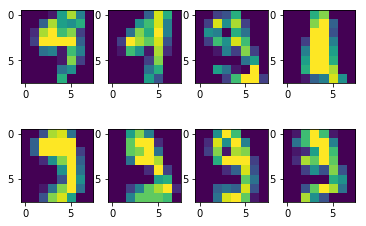

In [14]:
train_x, train_y, test_x, test_y = create_dataset_binary(class0=1, class1=9)

In [10]:
# reshape input as image
train_x = np.reshape(train_x, [len(train_y), 8, 8])
print('train_x shape', train_x.shape)
test_x = np.reshape(test_x, [len(test_y), 8, 8])
print('test_x shape', test_x.shape)

train_x shape (326, 8, 8)
test_x shape (36, 8, 8)


In [11]:
# we will make matrixes now and feed them into QCNN
train_x = np.array([make_matrixes_4x4(x, 8) for x in train_x])
print(train_x.shape)
test_x = np.array([make_matrixes_4x4(x, 8) for x in test_x])
print(test_x.shape)

(326, 9, 16)
(36, 9, 16)


In [13]:
lr = 0.0015
# steps = [10, 30, 50, 70, 100, 200, 300] #, 500, 700, 1000]
# steps = [10, 20, 30, 40, 50, 60, 70, 80, 90]
steps = [i for i in range(10, 810, 50)]
# steps = np.arange(500, 501, 10)
print(steps)
batch_size = 2

test_acc, test_loss = [], []
train_acc, train_loss = [], []

hyperparams = {'circuit': circuit,
               'task': 'supervised',
               'loss': myloss,
               'optimizer': 'Adam',
               'init_learning_rate': lr,
               'log_every': 1,
               'warm_start': False}

for step in steps:

    learner = CircuitLearner(hyperparams=hyperparams)

    learner.train_circuit(X=train_x, Y=train_y, steps=step, batch_size=batch_size)

    test_score = learner.score_circuit(X=test_x, Y=test_y,
                                       outputs_to_predictions=outputs_to_predictions)

    test_acc.append(test_score['accuracy'])
    test_loss.append(test_score['loss'])

    train_score = learner.score_circuit(X=train_x, Y=train_y,
                                       outputs_to_predictions=outputs_to_predictions)

    train_acc.append(train_score['accuracy'])
    train_loss.append(train_score['loss'])

[10, 60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610, 660, 710, 760]

----------------------------- 
 HYPERPARAMETERS: 

batch_size - None (default value)
circuit - User defined function.
decay - 0.0 (default value)
init_learning_rate - 0.0015
log_every - 1
loss - User defined function.
model_dir - None (default value)
optimizer - Adam
outputs_to_predictions - None (default value)
plot_every - 1 (default value)
print_log - True (default value)
regularization_strength - 0.1 (default value)
regularizer - No regularizer provided.
task - supervised
warm_start - False

 -----------------------------
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': 'worker', '_service': None, '_model_dir': 'logsAUTO', '_log_step_count_steps': 100, '_num_worker_replicas': 1, '_keep_checkpoint_max': 5, '_global_id_in_cluster': 0, '_save_checkpoints_steps': None, '_session_config': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7

INFO:tensorflow:Regularization = 0.0, Loss = 0.19217324, Cost = 0.19217324, Step = 33 (0.275 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2485159, Cost = 0.2485159, Step = 34 (0.259 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.32115483, Cost = 0.32115483, Step = 35 (0.304 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25332046, Cost = 0.25332046, Step = 36 (0.264 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25620282, Cost = 0.25620282, Step = 37 (0.275 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2524149, Cost = 0.2524149, Step = 38 (0.279 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25469893, Cost = 0.25469893, Step = 39 (0.298 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18859912, Cost = 0.18859912, Step = 40 (0.297 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25479105, Cost = 0.25479105, Step = 41 (0.299 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18877584, Cost = 0.18877584, Step = 42 (0.283 sec)
INFO:tensorflow:Regulari

INFO:tensorflow:Regularization = 0.0, Loss = 0.19501549, Cost = 0.19501549, Step = 31 (0.298 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.31567776, Cost = 0.31567776, Step = 32 (0.305 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19217324, Cost = 0.19217324, Step = 33 (0.292 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2485159, Cost = 0.2485159, Step = 34 (0.300 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.32115483, Cost = 0.32115483, Step = 35 (0.263 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25332046, Cost = 0.25332046, Step = 36 (0.252 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25620282, Cost = 0.25620282, Step = 37 (0.281 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2524149, Cost = 0.2524149, Step = 38 (0.296 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25469893, Cost = 0.25469893, Step = 39 (0.307 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18859912, Cost = 0.18859912, Step = 40 (0.275 sec)
INFO:tensorflow:Regulari

INFO:tensorflow:Restoring parameters from logsAUTO/model.ckpt-110
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2023-05-14-04:23:09
INFO:tensorflow:Saving dict for global step 110: accuracy = 0.4722222, global_step = 110, loss = 0.24599239
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-05-14-04:23:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from logsAUTO/model.ckpt-110
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2023-05-14-04:23:35
INFO:tensorflow:Saving dict for global step 110: accuracy = 0.506135, global_step = 110, loss = 0.24509045

----------------------------- 
 HYPERPARAMETERS: 

batch_size - 326
circuit - User defined function.
decay - 0.0
init_learning_rate -

INFO:tensorflow:Regularization = 0.0, Loss = 0.20981625, Cost = 0.20981625, Step = 62 (0.286 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.28579962, Cost = 0.28579962, Step = 63 (0.267 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25141358, Cost = 0.25141358, Step = 64 (0.303 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24707548, Cost = 0.24707548, Step = 65 (0.310 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27877465, Cost = 0.27877465, Step = 66 (0.305 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25134775, Cost = 0.25134775, Step = 67 (0.310 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24943429, Cost = 0.24943429, Step = 68 (0.294 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2500157, Cost = 0.2500157, Step = 69 (0.290 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25179583, Cost = 0.25179583, Step = 70 (0.310 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25009573, Cost = 0.25009573, Step = 71 (0.281 sec)
INFO:tensorflow:Regula

INFO:tensorflow:Regularization = 0.0, Loss = 0.25084078, Cost = 0.25084078, Step = 145 (0.282 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2251533, Cost = 0.2251533, Step = 146 (0.313 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.26037753, Cost = 0.26037753, Step = 147 (0.287 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.26348785, Cost = 0.26348785, Step = 148 (0.308 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23604499, Cost = 0.23604499, Step = 149 (0.307 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22508255, Cost = 0.22508255, Step = 150 (0.295 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2319421, Cost = 0.2319421, Step = 151 (0.294 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20687532, Cost = 0.20687532, Step = 152 (0.285 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23234606, Cost = 0.23234606, Step = 153 (0.292 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24538752, Cost = 0.24538752, Step = 154 (0.288 sec)
INFO:tensorflo

INFO:tensorflow:Regularization = 0.0, Loss = 0.31770635, Cost = 0.31770635, Step = 43 (0.284 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18735959, Cost = 0.18735959, Step = 44 (0.309 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2564778, Cost = 0.2564778, Step = 45 (0.277 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25188258, Cost = 0.25188258, Step = 46 (0.309 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25254732, Cost = 0.25254732, Step = 47 (0.304 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25465092, Cost = 0.25465092, Step = 48 (0.301 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.32367128, Cost = 0.32367128, Step = 49 (0.302 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2533712, Cost = 0.2533712, Step = 50 (0.307 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25622195, Cost = 0.25622195, Step = 51 (0.294 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25615138, Cost = 0.25615138, Step = 52 (0.286 sec)
INFO:tensorflow:Regulari

INFO:tensorflow:Regularization = 0.0, Loss = 0.24002309, Cost = 0.24002309, Step = 126 (0.300 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23839656, Cost = 0.23839656, Step = 127 (0.295 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23435323, Cost = 0.23435323, Step = 128 (0.314 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23689404, Cost = 0.23689404, Step = 129 (0.310 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2576805, Cost = 0.2576805, Step = 130 (0.312 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22995335, Cost = 0.22995335, Step = 131 (0.290 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22707418, Cost = 0.22707418, Step = 132 (0.262 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25747108, Cost = 0.25747108, Step = 133 (0.282 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24081695, Cost = 0.24081695, Step = 134 (0.302 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24888617, Cost = 0.24888617, Step = 135 (0.290 sec)
INFO:tensorf

INFO:tensorflow:Regularization = 0.0, Loss = 0.042515017, Cost = 0.042515017, Step = 209 (0.298 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.021770695, Cost = 0.021770695, Step = 210 (0.311 sec)
INFO:tensorflow:Saving checkpoints for 210 into logsAUTO/model.ckpt.
INFO:tensorflow:Loss for final step: 0.021770695.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-05-14-04:32:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from logsAUTO/model.ckpt-210
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2023-05-14-04:32:27
INFO:tensorflow:Saving dict for global step 210: accuracy = 0.9444444, global_step = 210, loss = 0.07240413
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-05-14-04:32:37
INFO:tensorflow:Graph was fin

INFO:tensorflow:Regularization = 0.0, Loss = 0.30526635, Cost = 0.30526635, Step = 57 (0.279 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20048678, Cost = 0.20048678, Step = 58 (0.290 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24895781, Cost = 0.24895781, Step = 59 (0.292 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25021073, Cost = 0.25021073, Step = 60 (0.275 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.29594943, Cost = 0.29594943, Step = 61 (0.290 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20981625, Cost = 0.20981625, Step = 62 (0.264 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.28579962, Cost = 0.28579962, Step = 63 (0.294 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25141358, Cost = 0.25141358, Step = 64 (0.296 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24707548, Cost = 0.24707548, Step = 65 (0.286 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27877465, Cost = 0.27877465, Step = 66 (0.277 sec)
INFO:tensorflow:Regu

INFO:tensorflow:Regularization = 0.0, Loss = 0.22191843, Cost = 0.22191843, Step = 140 (0.286 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22964397, Cost = 0.22964397, Step = 141 (0.285 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23881073, Cost = 0.23881073, Step = 142 (0.318 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2392452, Cost = 0.2392452, Step = 143 (0.308 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24919721, Cost = 0.24919721, Step = 144 (0.275 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25084078, Cost = 0.25084078, Step = 145 (0.272 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2251533, Cost = 0.2251533, Step = 146 (0.291 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.26037753, Cost = 0.26037753, Step = 147 (0.270 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.26348785, Cost = 0.26348785, Step = 148 (0.279 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23604499, Cost = 0.23604499, Step = 149 (0.292 sec)
INFO:tensorflo

INFO:tensorflow:Regularization = 0.0, Loss = 0.058575284, Cost = 0.058575284, Step = 222 (0.293 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.026433537, Cost = 0.026433537, Step = 223 (0.284 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.36183283, Cost = 0.36183283, Step = 224 (0.294 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.033891607, Cost = 0.033891607, Step = 225 (0.295 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.023641, Cost = 0.023641, Step = 226 (0.289 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.033737004, Cost = 0.033737004, Step = 227 (0.281 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.078048654, Cost = 0.078048654, Step = 228 (0.280 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.01981667, Cost = 0.01981667, Step = 229 (0.297 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.027566537, Cost = 0.027566537, Step = 230 (0.291 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.059865586, Cost = 0.059865586, Step = 231 (0.280 sec)


INFO:tensorflow:Regularization = 0.0, Loss = 0.29774287, Cost = 0.29774287, Step = 19 (0.297 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20475024, Cost = 0.20475024, Step = 20 (0.292 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20482354, Cost = 0.20482354, Step = 21 (0.289 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2565784, Cost = 0.2565784, Step = 22 (0.284 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19867963, Cost = 0.19867963, Step = 23 (0.303 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.30392888, Cost = 0.30392888, Step = 24 (0.286 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25312358, Cost = 0.25312358, Step = 25 (0.263 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3055841, Cost = 0.3055841, Step = 26 (0.295 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19955178, Cost = 0.19955178, Step = 27 (0.324 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20104688, Cost = 0.20104688, Step = 28 (0.299 sec)
INFO:tensorflow:Regulari

INFO:tensorflow:Regularization = 0.0, Loss = 0.24162541, Cost = 0.24162541, Step = 102 (0.314 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.29996705, Cost = 0.29996705, Step = 103 (0.272 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2910509, Cost = 0.2910509, Step = 104 (0.269 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21005197, Cost = 0.21005197, Step = 105 (0.295 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24330309, Cost = 0.24330309, Step = 106 (0.298 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21185236, Cost = 0.21185236, Step = 107 (0.291 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24972752, Cost = 0.24972752, Step = 108 (0.295 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24603742, Cost = 0.24603742, Step = 109 (0.291 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24069408, Cost = 0.24069408, Step = 110 (0.309 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.249831, Cost = 0.249831, Step = 111 (0.289 sec)
INFO:tensorflow:

INFO:tensorflow:Regularization = 0.0, Loss = 0.23586142, Cost = 0.23586142, Step = 186 (0.297 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18730637, Cost = 0.18730637, Step = 187 (0.308 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19452721, Cost = 0.19452721, Step = 188 (0.294 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20531982, Cost = 0.20531982, Step = 189 (0.296 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1950743, Cost = 0.1950743, Step = 190 (0.287 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24570918, Cost = 0.24570918, Step = 191 (0.297 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19593191, Cost = 0.19593191, Step = 192 (0.306 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21175706, Cost = 0.21175706, Step = 193 (0.288 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2077336, Cost = 0.2077336, Step = 194 (0.279 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.33389807, Cost = 0.33389807, Step = 195 (0.293 sec)
INFO:tensorflo

INFO:tensorflow:Regularization = 0.0, Loss = 0.0075176544, Cost = 0.0075176544, Step = 268 (0.296 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.03161836, Cost = 0.03161836, Step = 269 (0.314 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.329089, Cost = 0.329089, Step = 270 (0.300 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.35161695, Cost = 0.35161695, Step = 271 (0.303 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.022942219, Cost = 0.022942219, Step = 272 (0.299 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.05019527, Cost = 0.05019527, Step = 273 (0.292 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3060838, Cost = 0.3060838, Step = 274 (0.277 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.021815067, Cost = 0.021815067, Step = 275 (0.285 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.14157295, Cost = 0.14157295, Step = 276 (0.307 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.05142934, Cost = 0.05142934, Step = 277 (0.293 sec)
INFO:ten

INFO:tensorflow:Regularization = 0.0, Loss = 0.32333094, Cost = 0.32333094, Step = 14 (0.280 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2554514, Cost = 0.2554514, Step = 15 (0.285 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19920939, Cost = 0.19920939, Step = 16 (0.309 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2001299, Cost = 0.2001299, Step = 17 (0.306 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20615464, Cost = 0.20615464, Step = 18 (0.296 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.29774287, Cost = 0.29774287, Step = 19 (0.288 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20475024, Cost = 0.20475024, Step = 20 (0.281 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20482354, Cost = 0.20482354, Step = 21 (0.279 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2565784, Cost = 0.2565784, Step = 22 (0.290 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19867963, Cost = 0.19867963, Step = 23 (0.310 sec)
INFO:tensorflow:Regulariza

INFO:tensorflow:Regularization = 0.0, Loss = 0.2524678, Cost = 0.2524678, Step = 98 (0.301 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.30233866, Cost = 0.30233866, Step = 99 (0.312 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.30705133, Cost = 0.30705133, Step = 100 (0.307 sec)
INFO:tensorflow:global_step/sec: 2.82563
INFO:tensorflow:Regularization = 0.0, Loss = 0.25149763, Cost = 0.25149763, Step = 101 (0.310 sec)
INFO:tensorflow:loss = 0.25149763, step = 101 (35.399 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24162541, Cost = 0.24162541, Step = 102 (0.303 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.29996705, Cost = 0.29996705, Step = 103 (0.279 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2910509, Cost = 0.2910509, Step = 104 (0.277 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21005197, Cost = 0.21005197, Step = 105 (0.283 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24330309, Cost = 0.24330309, Step = 106 (0.295 sec)
INFO:tensorflow

INFO:tensorflow:Regularization = 0.0, Loss = 0.27448043, Cost = 0.27448043, Step = 181 (0.287 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16863653, Cost = 0.16863653, Step = 182 (0.300 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.28498203, Cost = 0.28498203, Step = 183 (0.278 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.26847354, Cost = 0.26847354, Step = 184 (0.292 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22601014, Cost = 0.22601014, Step = 185 (0.269 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23586142, Cost = 0.23586142, Step = 186 (0.277 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18730637, Cost = 0.18730637, Step = 187 (0.271 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19452721, Cost = 0.19452721, Step = 188 (0.263 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20531982, Cost = 0.20531982, Step = 189 (0.283 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1950743, Cost = 0.1950743, Step = 190 (0.260 sec)
INFO:tensorf

INFO:tensorflow:Regularization = 0.0, Loss = 0.00383054, Cost = 0.00383054, Step = 263 (0.301 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.09362463, Cost = 0.09362463, Step = 264 (0.288 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.015386634, Cost = 0.015386634, Step = 265 (0.282 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0015286308, Cost = 0.0015286308, Step = 266 (0.281 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0011239555, Cost = 0.0011239555, Step = 267 (0.285 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0075176544, Cost = 0.0075176544, Step = 268 (0.306 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.03161836, Cost = 0.03161836, Step = 269 (0.315 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.329089, Cost = 0.329089, Step = 270 (0.298 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.35161695, Cost = 0.35161695, Step = 271 (0.298 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.022942219, Cost = 0.022942219, Step = 272 (0.310 sec

INFO:tensorflow:Regularization = 0.0, Loss = 0.060463704, Cost = 0.060463704, Step = 344 (0.296 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.016722027, Cost = 0.016722027, Step = 345 (0.289 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15293841, Cost = 0.15293841, Step = 346 (0.295 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.021651966, Cost = 0.021651966, Step = 347 (0.287 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.05111838, Cost = 0.05111838, Step = 348 (0.297 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.01617613, Cost = 0.01617613, Step = 349 (0.305 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.09218765, Cost = 0.09218765, Step = 350 (0.276 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.013503166, Cost = 0.013503166, Step = 351 (0.312 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.04753074, Cost = 0.04753074, Step = 352 (0.304 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.018999591, Cost = 0.018999591, Step = 353 (0.280 sec)


INFO:tensorflow:Regularization = 0.0, Loss = 0.18877584, Cost = 0.18877584, Step = 42 (0.289 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.31770635, Cost = 0.31770635, Step = 43 (0.312 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18735959, Cost = 0.18735959, Step = 44 (0.301 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2564778, Cost = 0.2564778, Step = 45 (0.314 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25188258, Cost = 0.25188258, Step = 46 (0.305 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25254732, Cost = 0.25254732, Step = 47 (0.289 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25465092, Cost = 0.25465092, Step = 48 (0.268 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.32367128, Cost = 0.32367128, Step = 49 (0.309 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2533712, Cost = 0.2533712, Step = 50 (0.319 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25622195, Cost = 0.25622195, Step = 51 (0.303 sec)
INFO:tensorflow:Regulari

INFO:tensorflow:Regularization = 0.0, Loss = 0.23470604, Cost = 0.23470604, Step = 125 (0.304 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24002309, Cost = 0.24002309, Step = 126 (0.300 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23839656, Cost = 0.23839656, Step = 127 (0.306 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23435323, Cost = 0.23435323, Step = 128 (0.288 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23689404, Cost = 0.23689404, Step = 129 (0.326 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2576805, Cost = 0.2576805, Step = 130 (0.308 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22995335, Cost = 0.22995335, Step = 131 (0.292 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22707418, Cost = 0.22707418, Step = 132 (0.302 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25747108, Cost = 0.25747108, Step = 133 (0.313 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24081695, Cost = 0.24081695, Step = 134 (0.305 sec)
INFO:tensorf

INFO:tensorflow:Regularization = 0.0, Loss = 0.22018456, Cost = 0.22018456, Step = 208 (0.271 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.042515017, Cost = 0.042515017, Step = 209 (0.270 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.021770695, Cost = 0.021770695, Step = 210 (0.295 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.30948564, Cost = 0.30948564, Step = 211 (0.284 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0028776054, Cost = 0.0028776054, Step = 212 (0.278 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.48227575, Cost = 0.48227575, Step = 213 (0.293 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.07039048, Cost = 0.07039048, Step = 214 (0.285 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.041405488, Cost = 0.041405488, Step = 215 (0.297 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.09784548, Cost = 0.09784548, Step = 216 (0.273 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.044903196, Cost = 0.044903196, Step = 217 (0.293 sec

INFO:tensorflow:Regularization = 0.0, Loss = 0.043375395, Cost = 0.043375395, Step = 290 (0.291 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0105144195, Cost = 0.0105144195, Step = 291 (0.318 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.013297233, Cost = 0.013297233, Step = 292 (0.301 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3699965, Cost = 0.3699965, Step = 293 (0.309 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.010245759, Cost = 0.010245759, Step = 294 (0.291 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.02148673, Cost = 0.02148673, Step = 295 (0.304 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24894421, Cost = 0.24894421, Step = 296 (0.300 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.02553474, Cost = 0.02553474, Step = 297 (0.301 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.46840352, Cost = 0.46840352, Step = 298 (0.287 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.003170351, Cost = 0.003170351, Step = 299 (0.292 sec)


INFO:tensorflow:Regularization = 0.0, Loss = 0.25234672, Cost = 0.25234672, Step = 371 (0.299 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0133985905, Cost = 0.0133985905, Step = 372 (0.301 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.00405104, Cost = 0.00405104, Step = 373 (0.286 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.41131246, Cost = 0.41131246, Step = 374 (0.302 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0012771017, Cost = 0.0012771017, Step = 375 (0.298 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.486959, Cost = 0.486959, Step = 376 (0.287 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.07809846, Cost = 0.07809846, Step = 377 (0.292 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.131477, Cost = 0.131477, Step = 378 (0.285 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0053657508, Cost = 0.0053657508, Step = 379 (0.296 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.006077701, Cost = 0.006077701, Step = 380 (0.312 sec)
INFO

INFO:tensorflow:Regularization = 0.0, Loss = 0.2001299, Cost = 0.2001299, Step = 17 (0.282 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20615464, Cost = 0.20615464, Step = 18 (0.287 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.29774287, Cost = 0.29774287, Step = 19 (0.300 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20475024, Cost = 0.20475024, Step = 20 (0.308 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20482354, Cost = 0.20482354, Step = 21 (0.292 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2565784, Cost = 0.2565784, Step = 22 (0.301 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19867963, Cost = 0.19867963, Step = 23 (0.279 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.30392888, Cost = 0.30392888, Step = 24 (0.279 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25312358, Cost = 0.25312358, Step = 25 (0.316 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3055841, Cost = 0.3055841, Step = 26 (0.273 sec)
INFO:tensorflow:Regulariza

INFO:tensorflow:global_step/sec: 2.79579
INFO:tensorflow:Regularization = 0.0, Loss = 0.25149763, Cost = 0.25149763, Step = 101 (0.330 sec)
INFO:tensorflow:loss = 0.25149763, step = 101 (35.778 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24162541, Cost = 0.24162541, Step = 102 (0.298 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.29996705, Cost = 0.29996705, Step = 103 (0.266 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2910509, Cost = 0.2910509, Step = 104 (0.297 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21005197, Cost = 0.21005197, Step = 105 (0.282 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24330309, Cost = 0.24330309, Step = 106 (0.292 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21185236, Cost = 0.21185236, Step = 107 (0.293 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24972752, Cost = 0.24972752, Step = 108 (0.275 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24603742, Cost = 0.24603742, Step = 109 (0.289 sec)
INFO:tensor

INFO:tensorflow:Regularization = 0.0, Loss = 0.26847354, Cost = 0.26847354, Step = 184 (0.279 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22601014, Cost = 0.22601014, Step = 185 (0.262 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23586142, Cost = 0.23586142, Step = 186 (0.299 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18730637, Cost = 0.18730637, Step = 187 (0.289 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19452721, Cost = 0.19452721, Step = 188 (0.301 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20531982, Cost = 0.20531982, Step = 189 (0.296 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1950743, Cost = 0.1950743, Step = 190 (0.296 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24570918, Cost = 0.24570918, Step = 191 (0.311 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19593191, Cost = 0.19593191, Step = 192 (0.309 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21175706, Cost = 0.21175706, Step = 193 (0.319 sec)
INFO:tensorf

INFO:tensorflow:Regularization = 0.0, Loss = 0.0015286308, Cost = 0.0015286308, Step = 266 (0.294 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0011239555, Cost = 0.0011239555, Step = 267 (0.290 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0075176544, Cost = 0.0075176544, Step = 268 (0.277 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.03161836, Cost = 0.03161836, Step = 269 (0.307 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.329089, Cost = 0.329089, Step = 270 (0.314 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.35161695, Cost = 0.35161695, Step = 271 (0.296 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.022942219, Cost = 0.022942219, Step = 272 (0.274 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.05019527, Cost = 0.05019527, Step = 273 (0.306 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3060838, Cost = 0.3060838, Step = 274 (0.294 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.021815067, Cost = 0.021815067, Step = 275 (0.288 sec)


INFO:tensorflow:Regularization = 0.0, Loss = 0.021651966, Cost = 0.021651966, Step = 347 (0.290 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.05111838, Cost = 0.05111838, Step = 348 (0.255 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.01617613, Cost = 0.01617613, Step = 349 (0.285 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.09218765, Cost = 0.09218765, Step = 350 (0.322 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.013503166, Cost = 0.013503166, Step = 351 (0.277 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.04753074, Cost = 0.04753074, Step = 352 (0.292 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.018999591, Cost = 0.018999591, Step = 353 (0.319 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.31927368, Cost = 0.31927368, Step = 354 (0.294 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.029850839, Cost = 0.029850839, Step = 355 (0.303 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.29305047, Cost = 0.29305047, Step = 356 (0.286 sec)
IN

INFO:tensorflow:Regularization = 0.0, Loss = 0.0017084774, Cost = 0.0017084774, Step = 429 (0.275 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0005106986, Cost = 0.0005106986, Step = 430 (0.286 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.050963275, Cost = 0.050963275, Step = 431 (0.267 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.05655878, Cost = 0.05655878, Step = 432 (0.281 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.4048236, Cost = 0.4048236, Step = 433 (0.277 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.39319018, Cost = 0.39319018, Step = 434 (0.276 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11723038, Cost = 0.11723038, Step = 435 (0.273 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.028546847, Cost = 0.028546847, Step = 436 (0.302 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.07205568, Cost = 0.07205568, Step = 437 (0.288 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.031507704, Cost = 0.031507704, Step = 438 (0.300 sec

INFO:tensorflow:Regularization = 0.0, Loss = 0.3055841, Cost = 0.3055841, Step = 26 (0.281 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19955178, Cost = 0.19955178, Step = 27 (0.280 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20104688, Cost = 0.20104688, Step = 28 (0.306 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20009562, Cost = 0.20009562, Step = 29 (0.304 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2525896, Cost = 0.2525896, Step = 30 (0.290 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19501549, Cost = 0.19501549, Step = 31 (0.283 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.31567776, Cost = 0.31567776, Step = 32 (0.309 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19217324, Cost = 0.19217324, Step = 33 (0.291 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2485159, Cost = 0.2485159, Step = 34 (0.284 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.32115483, Cost = 0.32115483, Step = 35 (0.294 sec)
INFO:tensorflow:Regulariza

INFO:tensorflow:Regularization = 0.0, Loss = 0.24603742, Cost = 0.24603742, Step = 109 (0.266 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24069408, Cost = 0.24069408, Step = 110 (0.299 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.249831, Cost = 0.249831, Step = 111 (0.284 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24236187, Cost = 0.24236187, Step = 112 (0.304 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27022213, Cost = 0.27022213, Step = 113 (0.282 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.26762813, Cost = 0.26762813, Step = 114 (0.304 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22302085, Cost = 0.22302085, Step = 115 (0.300 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22727841, Cost = 0.22727841, Step = 116 (0.304 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25932598, Cost = 0.25932598, Step = 117 (0.282 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24995978, Cost = 0.24995978, Step = 118 (0.280 sec)
INFO:tensorflo

INFO:tensorflow:Regularization = 0.0, Loss = 0.21175706, Cost = 0.21175706, Step = 193 (0.312 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2077336, Cost = 0.2077336, Step = 194 (0.283 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.33389807, Cost = 0.33389807, Step = 195 (0.297 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17929399, Cost = 0.17929399, Step = 196 (0.298 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15846056, Cost = 0.15846056, Step = 197 (0.303 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22543351, Cost = 0.22543351, Step = 198 (0.304 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21909986, Cost = 0.21909986, Step = 199 (0.308 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23159176, Cost = 0.23159176, Step = 200 (0.288 sec)
INFO:tensorflow:global_step/sec: 3.40347
INFO:tensorflow:Regularization = 0.0, Loss = 0.15624183, Cost = 0.15624183, Step = 201 (0.313 sec)
INFO:tensorflow:loss = 0.15624183, step = 201 (29.382 sec)
INFO:tensor

INFO:tensorflow:Regularization = 0.0, Loss = 0.021815067, Cost = 0.021815067, Step = 275 (0.283 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.14157295, Cost = 0.14157295, Step = 276 (0.283 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.05142934, Cost = 0.05142934, Step = 277 (0.289 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0043168953, Cost = 0.0043168953, Step = 278 (0.317 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17421876, Cost = 0.17421876, Step = 279 (0.320 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0048347185, Cost = 0.0048347185, Step = 280 (0.297 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.44306865, Cost = 0.44306865, Step = 281 (0.281 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0026896573, Cost = 0.0026896573, Step = 282 (0.291 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.007410964, Cost = 0.007410964, Step = 283 (0.296 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.06577496, Cost = 0.06577496, Step = 284 (0.295

INFO:tensorflow:Regularization = 0.0, Loss = 0.29305047, Cost = 0.29305047, Step = 356 (0.282 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.022435322, Cost = 0.022435322, Step = 357 (0.290 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.79019964, Cost = 0.79019964, Step = 358 (0.282 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.027671881, Cost = 0.027671881, Step = 359 (0.289 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.019779503, Cost = 0.019779503, Step = 360 (0.293 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.056235395, Cost = 0.056235395, Step = 361 (0.292 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.09132358, Cost = 0.09132358, Step = 362 (0.296 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.08342197, Cost = 0.08342197, Step = 363 (0.295 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.01105807, Cost = 0.01105807, Step = 364 (0.301 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.040856823, Cost = 0.040856823, Step = 365 (0.283 sec)


INFO:tensorflow:Regularization = 0.0, Loss = 0.031507704, Cost = 0.031507704, Step = 438 (0.284 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.07255165, Cost = 0.07255165, Step = 439 (0.272 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.022988047, Cost = 0.022988047, Step = 440 (0.283 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.009173444, Cost = 0.009173444, Step = 441 (0.290 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.07174211, Cost = 0.07174211, Step = 442 (0.297 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.01486773, Cost = 0.01486773, Step = 443 (0.288 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3697828, Cost = 0.3697828, Step = 444 (0.283 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.009190483, Cost = 0.009190483, Step = 445 (0.257 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.003677216, Cost = 0.003677216, Step = 446 (0.309 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0068626218, Cost = 0.0068626218, Step = 447 (0.304 sec

INFO:tensorflow:Restoring parameters from logsAUTO/model.ckpt-510
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2023-05-14-05:06:40
INFO:tensorflow:Saving dict for global step 510: accuracy = 0.9018405, global_step = 510, loss = 0.09012714

----------------------------- 
 HYPERPARAMETERS: 

batch_size - 326
circuit - User defined function.
decay - 0.0
init_learning_rate - 0.0015
log_every - 1
loss - User defined function.
model_dir - logsAUTO
optimizer - Adam
outputs_to_predictions - <function outputs_to_predictions at 0x7fab27ecf840>
plot_every - 1
print_log - True
regularization_strength - 0.1
regularizer - User defined function.
task - supervised
warm_start - False

 -----------------------------
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': 'worker', '_service': None, '_model_dir': 'logsAUTO', '_log_step_count_steps': 100, '_num_worker_re

INFO:tensorflow:Regularization = 0.0, Loss = 0.25134775, Cost = 0.25134775, Step = 67 (0.271 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24943429, Cost = 0.24943429, Step = 68 (0.311 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2500157, Cost = 0.2500157, Step = 69 (0.310 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25179583, Cost = 0.25179583, Step = 70 (0.275 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25009573, Cost = 0.25009573, Step = 71 (0.246 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24936698, Cost = 0.24936698, Step = 72 (0.302 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24198003, Cost = 0.24198003, Step = 73 (0.317 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24622689, Cost = 0.24622689, Step = 74 (0.267 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24485677, Cost = 0.24485677, Step = 75 (0.311 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2512286, Cost = 0.2512286, Step = 76 (0.283 sec)
INFO:tensorflow:Regulari

INFO:tensorflow:Regularization = 0.0, Loss = 0.22508255, Cost = 0.22508255, Step = 150 (0.295 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2319421, Cost = 0.2319421, Step = 151 (0.283 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20687532, Cost = 0.20687532, Step = 152 (0.271 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23234606, Cost = 0.23234606, Step = 153 (0.284 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24538752, Cost = 0.24538752, Step = 154 (0.302 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22853255, Cost = 0.22853255, Step = 155 (0.304 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.26806876, Cost = 0.26806876, Step = 156 (0.323 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23637666, Cost = 0.23637666, Step = 157 (0.284 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22338541, Cost = 0.22338541, Step = 158 (0.278 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2744026, Cost = 0.2744026, Step = 159 (0.277 sec)
INFO:tensorflo

INFO:tensorflow:Regularization = 0.0, Loss = 0.07331796, Cost = 0.07331796, Step = 232 (0.294 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.48019046, Cost = 0.48019046, Step = 233 (0.302 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.44287905, Cost = 0.44287905, Step = 234 (0.283 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25460213, Cost = 0.25460213, Step = 235 (0.285 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.14720288, Cost = 0.14720288, Step = 236 (0.283 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.009718867, Cost = 0.009718867, Step = 237 (0.285 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.5328703, Cost = 0.5328703, Step = 238 (0.289 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.29337335, Cost = 0.29337335, Step = 239 (0.288 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.122151576, Cost = 0.122151576, Step = 240 (0.278 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.069387555, Cost = 0.069387555, Step = 241 (0.280 sec)
INFO:t

INFO:tensorflow:Regularization = 0.0, Loss = 0.0074131563, Cost = 0.0074131563, Step = 313 (0.292 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2829726, Cost = 0.2829726, Step = 314 (0.268 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.004412172, Cost = 0.004412172, Step = 315 (0.300 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.06553605, Cost = 0.06553605, Step = 316 (0.299 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21746255, Cost = 0.21746255, Step = 317 (0.291 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.038484417, Cost = 0.038484417, Step = 318 (0.308 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.014842094, Cost = 0.014842094, Step = 319 (0.270 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.011667872, Cost = 0.011667872, Step = 320 (0.297 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.032807175, Cost = 0.032807175, Step = 321 (0.310 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.013508468, Cost = 0.013508468, Step = 322 (0.319 s

INFO:tensorflow:Regularization = 0.0, Loss = 0.4244733, Cost = 0.4244733, Step = 396 (0.304 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.4378176, Cost = 0.4378176, Step = 397 (0.313 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.028885804, Cost = 0.028885804, Step = 398 (0.300 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.020170042, Cost = 0.020170042, Step = 399 (0.285 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.017377157, Cost = 0.017377157, Step = 400 (0.289 sec)
INFO:tensorflow:global_step/sec: 3.3992
INFO:tensorflow:Regularization = 0.0, Loss = 0.38969433, Cost = 0.38969433, Step = 401 (0.313 sec)
INFO:tensorflow:loss = 0.38969433, step = 401 (29.421 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22168115, Cost = 0.22168115, Step = 402 (0.287 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.10769076, Cost = 0.10769076, Step = 403 (0.267 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.052173067, Cost = 0.052173067, Step = 404 (0.305 sec)
INFO:t

INFO:tensorflow:Regularization = 0.0, Loss = 0.31607425, Cost = 0.31607425, Step = 477 (0.300 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0008872826, Cost = 0.0008872826, Step = 478 (0.308 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.114952244, Cost = 0.114952244, Step = 479 (0.308 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.13831428, Cost = 0.13831428, Step = 480 (0.313 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.034085058, Cost = 0.034085058, Step = 481 (0.281 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.027808294, Cost = 0.027808294, Step = 482 (0.293 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.013807622, Cost = 0.013807622, Step = 483 (0.278 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.046368986, Cost = 0.046368986, Step = 484 (0.283 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.032403402, Cost = 0.032403402, Step = 485 (0.267 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18459018, Cost = 0.18459018, Step = 486 (0.296

INFO:tensorflow:Regularization = 0.0, Loss = 0.048807286, Cost = 0.048807286, Step = 558 (0.288 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.36353832, Cost = 0.36353832, Step = 559 (0.308 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.4554922, Cost = 0.4554922, Step = 560 (0.295 sec)
INFO:tensorflow:Saving checkpoints for 560 into logsAUTO/model.ckpt.
INFO:tensorflow:Loss for final step: 0.4554922.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-05-14-05:12:34
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from logsAUTO/model.ckpt-560
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2023-05-14-05:12:40
INFO:tensorflow:Saving dict for global step 560: accuracy = 0.9722222, global_step = 560, loss = 0.045902412
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling mode

INFO:tensorflow:Regularization = 0.0, Loss = 0.25292253, Cost = 0.25292253, Step = 56 (0.300 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.30526635, Cost = 0.30526635, Step = 57 (0.304 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20048678, Cost = 0.20048678, Step = 58 (0.289 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24895781, Cost = 0.24895781, Step = 59 (0.294 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25021073, Cost = 0.25021073, Step = 60 (0.296 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.29594943, Cost = 0.29594943, Step = 61 (0.283 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20981625, Cost = 0.20981625, Step = 62 (0.285 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.28579962, Cost = 0.28579962, Step = 63 (0.279 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25141358, Cost = 0.25141358, Step = 64 (0.282 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24707548, Cost = 0.24707548, Step = 65 (0.312 sec)
INFO:tensorflow:Regu

INFO:tensorflow:Regularization = 0.0, Loss = 0.2529442, Cost = 0.2529442, Step = 139 (0.280 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22191843, Cost = 0.22191843, Step = 140 (0.301 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22964397, Cost = 0.22964397, Step = 141 (0.286 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23881073, Cost = 0.23881073, Step = 142 (0.302 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2392452, Cost = 0.2392452, Step = 143 (0.276 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24919721, Cost = 0.24919721, Step = 144 (0.294 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25084078, Cost = 0.25084078, Step = 145 (0.295 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2251533, Cost = 0.2251533, Step = 146 (0.302 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.26037753, Cost = 0.26037753, Step = 147 (0.290 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.26348785, Cost = 0.26348785, Step = 148 (0.283 sec)
INFO:tensorflow:

INFO:tensorflow:Regularization = 0.0, Loss = 0.043351885, Cost = 0.043351885, Step = 221 (0.286 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.058575284, Cost = 0.058575284, Step = 222 (0.307 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.026433537, Cost = 0.026433537, Step = 223 (0.286 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.36183283, Cost = 0.36183283, Step = 224 (0.314 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.033891607, Cost = 0.033891607, Step = 225 (0.297 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.023641, Cost = 0.023641, Step = 226 (0.315 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.033737004, Cost = 0.033737004, Step = 227 (0.304 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.078048654, Cost = 0.078048654, Step = 228 (0.294 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.01981667, Cost = 0.01981667, Step = 229 (0.288 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.027566537, Cost = 0.027566537, Step = 230 (0.281 sec)


INFO:tensorflow:Regularization = 0.0, Loss = 0.047053736, Cost = 0.047053736, Step = 303 (0.303 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.005023861, Cost = 0.005023861, Step = 304 (0.308 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.027146116, Cost = 0.027146116, Step = 305 (0.305 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.050813723, Cost = 0.050813723, Step = 306 (0.303 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.016492525, Cost = 0.016492525, Step = 307 (0.316 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0077306735, Cost = 0.0077306735, Step = 308 (0.315 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.111796476, Cost = 0.111796476, Step = 309 (0.281 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.035850074, Cost = 0.035850074, Step = 310 (0.295 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0036167311, Cost = 0.0036167311, Step = 311 (0.298 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.00955973, Cost = 0.00955973, Step = 312 

INFO:tensorflow:Regularization = 0.0, Loss = 0.0576075, Cost = 0.0576075, Step = 385 (0.298 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.011275742, Cost = 0.011275742, Step = 386 (0.266 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.089157365, Cost = 0.089157365, Step = 387 (0.301 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.09182177, Cost = 0.09182177, Step = 388 (0.297 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.014955063, Cost = 0.014955063, Step = 389 (0.306 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.118441105, Cost = 0.118441105, Step = 390 (0.283 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15404975, Cost = 0.15404975, Step = 391 (0.292 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.003822562, Cost = 0.003822562, Step = 392 (0.306 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.027168572, Cost = 0.027168572, Step = 393 (0.287 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.017455198, Cost = 0.017455198, Step = 394 (0.284 sec

INFO:tensorflow:Regularization = 0.0, Loss = 0.04239317, Cost = 0.04239317, Step = 466 (0.302 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.014235888, Cost = 0.014235888, Step = 467 (0.298 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.047898773, Cost = 0.047898773, Step = 468 (0.309 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.10621472, Cost = 0.10621472, Step = 469 (0.301 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.067291014, Cost = 0.067291014, Step = 470 (0.283 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.044928834, Cost = 0.044928834, Step = 471 (0.274 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.093122154, Cost = 0.093122154, Step = 472 (0.286 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.06045512, Cost = 0.06045512, Step = 473 (0.311 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.010998689, Cost = 0.010998689, Step = 474 (0.327 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.015944388, Cost = 0.015944388, Step = 475 (0.286 s

INFO:tensorflow:Regularization = 0.0, Loss = 0.022849094, Cost = 0.022849094, Step = 547 (0.292 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.040634964, Cost = 0.040634964, Step = 548 (0.305 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.012898174, Cost = 0.012898174, Step = 549 (0.298 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.08969505, Cost = 0.08969505, Step = 550 (0.272 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.07741384, Cost = 0.07741384, Step = 551 (0.279 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.008394752, Cost = 0.008394752, Step = 552 (0.278 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15045214, Cost = 0.15045214, Step = 553 (0.286 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11112194, Cost = 0.11112194, Step = 554 (0.288 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0015702904, Cost = 0.0015702904, Step = 555 (0.268 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.024077347, Cost = 0.024077347, Step = 556 (0.291 s

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into logsAUTO/model.ckpt.
INFO:tensorflow:Regularization = 0.0, Loss = 0.1419447, Cost = 0.1419447, Step = 1
INFO:tensorflow:loss = 0.1419447, step = 1
INFO:tensorflow:Regularization = 0.0, Loss = 0.27519828, Cost = 0.27519828, Step = 2 (6.742 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.26774523, Cost = 0.26774523, Step = 3 (0.290 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.42331982, Cost = 0.42331982, Step = 4 (0.301 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.4041279, Cost = 0.4041279, Step = 5 (0.303 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27512002, Cost = 0.27512002, Step = 6 (0.305 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.26295856, Cost = 0.26295856, Step = 7 (0

INFO:tensorflow:Regularization = 0.0, Loss = 0.24060905, Cost = 0.24060905, Step = 82 (0.308 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23707761, Cost = 0.23707761, Step = 83 (0.310 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24671352, Cost = 0.24671352, Step = 84 (0.295 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23231208, Cost = 0.23231208, Step = 85 (0.287 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22985318, Cost = 0.22985318, Step = 86 (0.279 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22977844, Cost = 0.22977844, Step = 87 (0.302 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24258086, Cost = 0.24258086, Step = 88 (0.304 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24586046, Cost = 0.24586046, Step = 89 (0.294 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.28299856, Cost = 0.28299856, Step = 90 (0.298 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2182878, Cost = 0.2182878, Step = 91 (0.306 sec)
INFO:tensorflow:Regula

INFO:tensorflow:Regularization = 0.0, Loss = 0.22778578, Cost = 0.22778578, Step = 165 (0.276 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23898599, Cost = 0.23898599, Step = 166 (0.311 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22631267, Cost = 0.22631267, Step = 167 (0.273 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21332051, Cost = 0.21332051, Step = 168 (0.288 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24677472, Cost = 0.24677472, Step = 169 (0.278 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2103395, Cost = 0.2103395, Step = 170 (0.289 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20584764, Cost = 0.20584764, Step = 171 (0.301 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2298732, Cost = 0.2298732, Step = 172 (0.276 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2565568, Cost = 0.2565568, Step = 173 (0.287 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2605545, Cost = 0.2605545, Step = 174 (0.280 sec)
INFO:tensorflow:Re

INFO:tensorflow:Regularization = 0.0, Loss = 0.08190234, Cost = 0.08190234, Step = 247 (0.309 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.062236123, Cost = 0.062236123, Step = 248 (0.301 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.05389735, Cost = 0.05389735, Step = 249 (0.302 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.060572337, Cost = 0.060572337, Step = 250 (0.298 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0779859, Cost = 0.0779859, Step = 251 (0.274 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.07208177, Cost = 0.07208177, Step = 252 (0.298 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24099281, Cost = 0.24099281, Step = 253 (0.287 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.018795371, Cost = 0.018795371, Step = 254 (0.292 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0015757371, Cost = 0.0015757371, Step = 255 (0.305 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.046184193, Cost = 0.046184193, Step = 256 (0.285 sec)


INFO:tensorflow:Regularization = 0.0, Loss = 0.01647729, Cost = 0.01647729, Step = 328 (0.294 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.30620062, Cost = 0.30620062, Step = 329 (0.270 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.037155878, Cost = 0.037155878, Step = 330 (0.277 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.02282033, Cost = 0.02282033, Step = 331 (0.277 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2783298, Cost = 0.2783298, Step = 332 (0.288 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.06430527, Cost = 0.06430527, Step = 333 (0.269 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.024292521, Cost = 0.024292521, Step = 334 (0.275 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17067696, Cost = 0.17067696, Step = 335 (0.292 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15740475, Cost = 0.15740475, Step = 336 (0.293 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19168085, Cost = 0.19168085, Step = 337 (0.301 sec)
INFO:ten

INFO:tensorflow:Regularization = 0.0, Loss = 0.05968734, Cost = 0.05968734, Step = 410 (0.293 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.13842672, Cost = 0.13842672, Step = 411 (0.284 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.015227812, Cost = 0.015227812, Step = 412 (0.279 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.03970542, Cost = 0.03970542, Step = 413 (0.293 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.03735444, Cost = 0.03735444, Step = 414 (0.308 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.04218322, Cost = 0.04218322, Step = 415 (0.275 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21257776, Cost = 0.21257776, Step = 416 (0.304 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.02528428, Cost = 0.02528428, Step = 417 (0.311 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.01905608, Cost = 0.01905608, Step = 418 (0.271 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0662283, Cost = 0.0662283, Step = 419 (0.297 sec)
INFO:tenso

INFO:tensorflow:Regularization = 0.0, Loss = 0.36823836, Cost = 0.36823836, Step = 492 (0.322 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.029792614, Cost = 0.029792614, Step = 493 (0.296 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16513816, Cost = 0.16513816, Step = 494 (0.288 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.09735894, Cost = 0.09735894, Step = 495 (0.286 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.014832724, Cost = 0.014832724, Step = 496 (0.305 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21957245, Cost = 0.21957245, Step = 497 (0.286 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.44833043, Cost = 0.44833043, Step = 498 (0.283 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.061951503, Cost = 0.061951503, Step = 499 (0.288 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20151769, Cost = 0.20151769, Step = 500 (0.294 sec)
INFO:tensorflow:global_step/sec: 3.43499
INFO:tensorflow:Regularization = 0.0, Loss = 0.07869356, Cost 

INFO:tensorflow:Regularization = 0.0, Loss = 0.04602455, Cost = 0.04602455, Step = 573 (0.298 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.09796167, Cost = 0.09796167, Step = 574 (0.307 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.009212709, Cost = 0.009212709, Step = 575 (0.292 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.02579318, Cost = 0.02579318, Step = 576 (0.296 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.03838438, Cost = 0.03838438, Step = 577 (0.278 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.03056595, Cost = 0.03056595, Step = 578 (0.314 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23344366, Cost = 0.23344366, Step = 579 (0.291 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.021494295, Cost = 0.021494295, Step = 580 (0.285 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.017372847, Cost = 0.017372847, Step = 581 (0.305 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.021122918, Cost = 0.021122918, Step = 582 (0.310 sec)
IN

INFO:tensorflow:Regularization = 0.0, Loss = 0.009801276, Cost = 0.009801276, Step = 654 (0.286 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.39467245, Cost = 0.39467245, Step = 655 (0.274 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.007451097, Cost = 0.007451097, Step = 656 (0.283 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.103443824, Cost = 0.103443824, Step = 657 (0.302 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.061754353, Cost = 0.061754353, Step = 658 (0.298 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.021355847, Cost = 0.021355847, Step = 659 (0.285 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18532178, Cost = 0.18532178, Step = 660 (0.307 sec)
INFO:tensorflow:Saving checkpoints for 660 into logsAUTO/model.ckpt.
INFO:tensorflow:Loss for final step: 0.18532178.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-05-14-05:26:20
INFO:tensorflow:Graph was finalized.
INFO:tenso

INFO:tensorflow:Regularization = 0.0, Loss = 0.25615138, Cost = 0.25615138, Step = 52 (0.289 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24941577, Cost = 0.24941577, Step = 53 (0.282 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2507589, Cost = 0.2507589, Step = 54 (0.275 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3131045, Cost = 0.3131045, Step = 55 (0.294 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25292253, Cost = 0.25292253, Step = 56 (0.285 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.30526635, Cost = 0.30526635, Step = 57 (0.282 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20048678, Cost = 0.20048678, Step = 58 (0.298 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24895781, Cost = 0.24895781, Step = 59 (0.317 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25021073, Cost = 0.25021073, Step = 60 (0.310 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.29594943, Cost = 0.29594943, Step = 61 (0.279 sec)
INFO:tensorflow:Regulari

INFO:tensorflow:Regularization = 0.0, Loss = 0.24888617, Cost = 0.24888617, Step = 135 (0.300 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21513024, Cost = 0.21513024, Step = 136 (0.325 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.28087842, Cost = 0.28087842, Step = 137 (0.279 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24428144, Cost = 0.24428144, Step = 138 (0.307 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2529442, Cost = 0.2529442, Step = 139 (0.276 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22191843, Cost = 0.22191843, Step = 140 (0.286 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22964397, Cost = 0.22964397, Step = 141 (0.310 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23881073, Cost = 0.23881073, Step = 142 (0.264 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2392452, Cost = 0.2392452, Step = 143 (0.286 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24919721, Cost = 0.24919721, Step = 144 (0.297 sec)
INFO:tensorflo

INFO:tensorflow:Regularization = 0.0, Loss = 0.044903196, Cost = 0.044903196, Step = 217 (0.288 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0017987718, Cost = 0.0017987718, Step = 218 (0.275 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11342243, Cost = 0.11342243, Step = 219 (0.289 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.018906249, Cost = 0.018906249, Step = 220 (0.282 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.043351885, Cost = 0.043351885, Step = 221 (0.298 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.058575284, Cost = 0.058575284, Step = 222 (0.297 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.026433537, Cost = 0.026433537, Step = 223 (0.306 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.36183283, Cost = 0.36183283, Step = 224 (0.272 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.033891607, Cost = 0.033891607, Step = 225 (0.285 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.023641, Cost = 0.023641, Step = 226 (0.293 sec

INFO:tensorflow:Regularization = 0.0, Loss = 0.003170351, Cost = 0.003170351, Step = 299 (0.287 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.6267029, Cost = 0.6267029, Step = 300 (0.293 sec)
INFO:tensorflow:global_step/sec: 3.43143
INFO:tensorflow:Regularization = 0.0, Loss = 0.4170807, Cost = 0.4170807, Step = 301 (0.295 sec)
INFO:tensorflow:loss = 0.4170807, step = 301 (29.142 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.017250406, Cost = 0.017250406, Step = 302 (0.302 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.047053736, Cost = 0.047053736, Step = 303 (0.290 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.005023861, Cost = 0.005023861, Step = 304 (0.289 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.027146116, Cost = 0.027146116, Step = 305 (0.284 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.050813723, Cost = 0.050813723, Step = 306 (0.298 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.016492525, Cost = 0.016492525, Step = 307 (0.323 sec)


INFO:tensorflow:Regularization = 0.0, Loss = 0.021672156, Cost = 0.021672156, Step = 381 (0.275 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.05577334, Cost = 0.05577334, Step = 382 (0.314 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.014810901, Cost = 0.014810901, Step = 383 (0.295 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.02153928, Cost = 0.02153928, Step = 384 (0.292 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0576075, Cost = 0.0576075, Step = 385 (0.307 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.011275742, Cost = 0.011275742, Step = 386 (0.311 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.089157365, Cost = 0.089157365, Step = 387 (0.292 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.09182177, Cost = 0.09182177, Step = 388 (0.305 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.014955063, Cost = 0.014955063, Step = 389 (0.297 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.118441105, Cost = 0.118441105, Step = 390 (0.299 sec)


INFO:tensorflow:Regularization = 0.0, Loss = 0.006948675, Cost = 0.006948675, Step = 462 (0.302 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.5425524, Cost = 0.5425524, Step = 463 (0.310 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.31620657, Cost = 0.31620657, Step = 464 (0.311 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.087247066, Cost = 0.087247066, Step = 465 (0.307 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.04239317, Cost = 0.04239317, Step = 466 (0.273 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.014235888, Cost = 0.014235888, Step = 467 (0.305 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.047898773, Cost = 0.047898773, Step = 468 (0.306 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.10621472, Cost = 0.10621472, Step = 469 (0.315 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.067291014, Cost = 0.067291014, Step = 470 (0.269 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.044928834, Cost = 0.044928834, Step = 471 (0.313 sec)


INFO:tensorflow:Regularization = 0.0, Loss = 0.00645552, Cost = 0.00645552, Step = 543 (0.272 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0069139507, Cost = 0.0069139507, Step = 544 (0.292 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.058282223, Cost = 0.058282223, Step = 545 (0.311 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0077986876, Cost = 0.0077986876, Step = 546 (0.304 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.022849094, Cost = 0.022849094, Step = 547 (0.280 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.040634964, Cost = 0.040634964, Step = 548 (0.293 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.012898174, Cost = 0.012898174, Step = 549 (0.272 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.08969505, Cost = 0.08969505, Step = 550 (0.288 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.07741384, Cost = 0.07741384, Step = 551 (0.290 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.008394752, Cost = 0.008394752, Step = 552 (0.3

INFO:tensorflow:Regularization = 0.0, Loss = 0.4529029, Cost = 0.4529029, Step = 624 (0.302 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.002946456, Cost = 0.002946456, Step = 625 (0.293 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.56253266, Cost = 0.56253266, Step = 626 (0.297 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25480908, Cost = 0.25480908, Step = 627 (0.294 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.07374883, Cost = 0.07374883, Step = 628 (0.293 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.042652786, Cost = 0.042652786, Step = 629 (0.309 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.013952035, Cost = 0.013952035, Step = 630 (0.255 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.076431304, Cost = 0.076431304, Step = 631 (0.305 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.094297595, Cost = 0.094297595, Step = 632 (0.283 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.04987734, Cost = 0.04987734, Step = 633 (0.279 sec)
IN

INFO:tensorflow:Regularization = 0.0, Loss = 0.006249632, Cost = 0.006249632, Step = 706 (0.313 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.005414933, Cost = 0.005414933, Step = 707 (0.308 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.051201906, Cost = 0.051201906, Step = 708 (0.281 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0076914323, Cost = 0.0076914323, Step = 709 (0.295 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.020976035, Cost = 0.020976035, Step = 710 (0.289 sec)
INFO:tensorflow:Saving checkpoints for 710 into logsAUTO/model.ckpt.
INFO:tensorflow:Loss for final step: 0.020976035.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-05-14-05:33:33
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from logsAUTO/model.ckpt-710
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finishe

INFO:tensorflow:Regularization = 0.0, Loss = 0.2507589, Cost = 0.2507589, Step = 54 (0.293 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3131045, Cost = 0.3131045, Step = 55 (0.298 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25292253, Cost = 0.25292253, Step = 56 (0.285 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.30526635, Cost = 0.30526635, Step = 57 (0.295 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20048678, Cost = 0.20048678, Step = 58 (0.288 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24895781, Cost = 0.24895781, Step = 59 (0.299 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25021073, Cost = 0.25021073, Step = 60 (0.295 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.29594943, Cost = 0.29594943, Step = 61 (0.279 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20981625, Cost = 0.20981625, Step = 62 (0.276 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.28579962, Cost = 0.28579962, Step = 63 (0.304 sec)
INFO:tensorflow:Regulari

INFO:tensorflow:Regularization = 0.0, Loss = 0.28087842, Cost = 0.28087842, Step = 137 (0.299 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24428144, Cost = 0.24428144, Step = 138 (0.284 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2529442, Cost = 0.2529442, Step = 139 (0.277 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22191843, Cost = 0.22191843, Step = 140 (0.283 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22964397, Cost = 0.22964397, Step = 141 (0.295 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23881073, Cost = 0.23881073, Step = 142 (0.283 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2392452, Cost = 0.2392452, Step = 143 (0.324 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24919721, Cost = 0.24919721, Step = 144 (0.303 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25084078, Cost = 0.25084078, Step = 145 (0.269 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2251533, Cost = 0.2251533, Step = 146 (0.313 sec)
INFO:tensorflow:

INFO:tensorflow:Regularization = 0.0, Loss = 0.11342243, Cost = 0.11342243, Step = 219 (0.288 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.018906249, Cost = 0.018906249, Step = 220 (0.276 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.043351885, Cost = 0.043351885, Step = 221 (0.320 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.058575284, Cost = 0.058575284, Step = 222 (0.316 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.026433537, Cost = 0.026433537, Step = 223 (0.311 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.36183283, Cost = 0.36183283, Step = 224 (0.302 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.033891607, Cost = 0.033891607, Step = 225 (0.312 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.023641, Cost = 0.023641, Step = 226 (0.269 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.033737004, Cost = 0.033737004, Step = 227 (0.286 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.078048654, Cost = 0.078048654, Step = 228 (0.305 sec)


INFO:tensorflow:Regularization = 0.0, Loss = 0.4170807, Cost = 0.4170807, Step = 301 (0.316 sec)
INFO:tensorflow:loss = 0.4170807, step = 301 (29.566 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.017250406, Cost = 0.017250406, Step = 302 (0.310 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.047053736, Cost = 0.047053736, Step = 303 (0.304 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.005023861, Cost = 0.005023861, Step = 304 (0.317 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.027146116, Cost = 0.027146116, Step = 305 (0.294 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.050813723, Cost = 0.050813723, Step = 306 (0.284 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.016492525, Cost = 0.016492525, Step = 307 (0.287 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0077306735, Cost = 0.0077306735, Step = 308 (0.316 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.111796476, Cost = 0.111796476, Step = 309 (0.301 sec)
INFO:tensorflow:Regularization = 0.

INFO:tensorflow:Regularization = 0.0, Loss = 0.014810901, Cost = 0.014810901, Step = 383 (0.286 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.02153928, Cost = 0.02153928, Step = 384 (0.287 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0576075, Cost = 0.0576075, Step = 385 (0.305 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.011275742, Cost = 0.011275742, Step = 386 (0.290 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.089157365, Cost = 0.089157365, Step = 387 (0.294 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.09182177, Cost = 0.09182177, Step = 388 (0.291 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.014955063, Cost = 0.014955063, Step = 389 (0.302 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.118441105, Cost = 0.118441105, Step = 390 (0.297 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15404975, Cost = 0.15404975, Step = 391 (0.293 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.003822562, Cost = 0.003822562, Step = 392 (0.313 sec)


INFO:tensorflow:Regularization = 0.0, Loss = 0.31620657, Cost = 0.31620657, Step = 464 (0.290 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.087247066, Cost = 0.087247066, Step = 465 (0.282 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.04239317, Cost = 0.04239317, Step = 466 (0.292 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.014235888, Cost = 0.014235888, Step = 467 (0.312 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.047898773, Cost = 0.047898773, Step = 468 (0.296 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.10621472, Cost = 0.10621472, Step = 469 (0.285 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.067291014, Cost = 0.067291014, Step = 470 (0.303 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.044928834, Cost = 0.044928834, Step = 471 (0.308 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.093122154, Cost = 0.093122154, Step = 472 (0.303 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.06045512, Cost = 0.06045512, Step = 473 (0.287 sec

INFO:tensorflow:Regularization = 0.0, Loss = 0.058282223, Cost = 0.058282223, Step = 545 (0.297 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0077986876, Cost = 0.0077986876, Step = 546 (0.286 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.022849094, Cost = 0.022849094, Step = 547 (0.300 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.040634964, Cost = 0.040634964, Step = 548 (0.269 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.012898174, Cost = 0.012898174, Step = 549 (0.285 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.08969505, Cost = 0.08969505, Step = 550 (0.299 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.07741384, Cost = 0.07741384, Step = 551 (0.307 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.008394752, Cost = 0.008394752, Step = 552 (0.327 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15045214, Cost = 0.15045214, Step = 553 (0.287 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11112194, Cost = 0.11112194, Step = 554 (0.277 s

INFO:tensorflow:Regularization = 0.0, Loss = 0.56253266, Cost = 0.56253266, Step = 626 (0.302 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25480908, Cost = 0.25480908, Step = 627 (0.294 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.07374883, Cost = 0.07374883, Step = 628 (0.298 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.042652786, Cost = 0.042652786, Step = 629 (0.291 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.013952035, Cost = 0.013952035, Step = 630 (0.306 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.076431304, Cost = 0.076431304, Step = 631 (0.286 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.094297595, Cost = 0.094297595, Step = 632 (0.276 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.04987734, Cost = 0.04987734, Step = 633 (0.267 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.019893266, Cost = 0.019893266, Step = 634 (0.282 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.10398938, Cost = 0.10398938, Step = 635 (0.301 sec)


INFO:tensorflow:Regularization = 0.0, Loss = 0.005414933, Cost = 0.005414933, Step = 707 (0.295 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.051201906, Cost = 0.051201906, Step = 708 (0.295 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0076914323, Cost = 0.0076914323, Step = 709 (0.309 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.020976035, Cost = 0.020976035, Step = 710 (0.312 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.03979627, Cost = 0.03979627, Step = 711 (0.303 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.012794593, Cost = 0.012794593, Step = 712 (0.291 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0793573, Cost = 0.0793573, Step = 713 (0.293 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.08234542, Cost = 0.08234542, Step = 714 (0.314 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.009330038, Cost = 0.009330038, Step = 715 (0.279 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16821897, Cost = 0.16821897, Step = 716 (0.309 sec

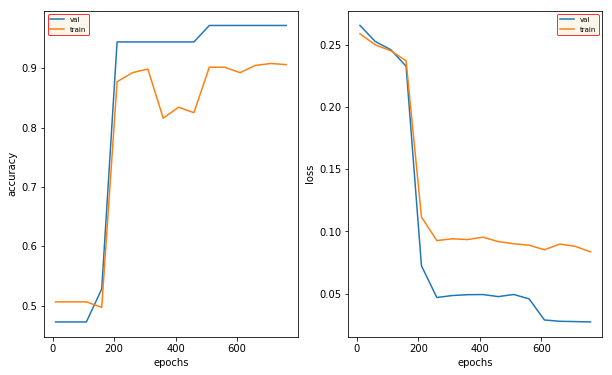

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 6))

ax[0].plot(steps, test_acc, label = 'val')
ax[0].plot(steps, train_acc, label = 'train')
ax[0].legend(fontsize=7, ncol=1, facecolor='oldlace', edgecolor='r')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('accuracy')


ax[1].plot(steps, test_loss, label = 'val')
ax[1].plot(steps, train_loss, label = 'train')
ax[1].legend(fontsize=7, ncol=1, facecolor='oldlace', edgecolor='r')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('loss')

plt.show()

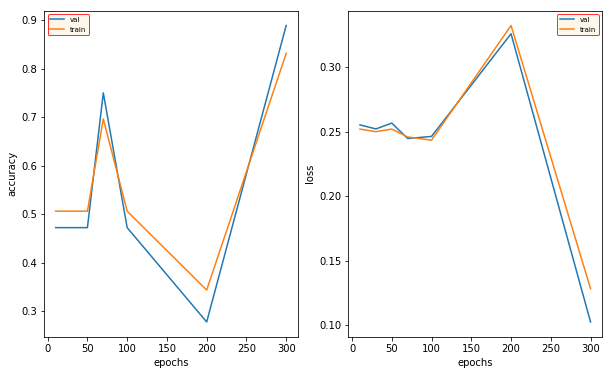

In [16]:
print(steps)
print(test_acc)
print(test_loss)
print(train_acc)
print(train_loss)

[10, 60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610, 660, 710, 760]
[0.4722222, 0.4722222, 0.4722222, 0.5277778, 0.9444444, 0.9444444, 0.9444444, 0.8611111, 0.8888889, 0.8888889, 0.9722222, 0.9722222, 0.9722222, 0.9722222, 0.8888889, 0.8888889]
[0.26539844, 0.25247163, 0.24599239, 0.23269568, 0.07240413, 0.04695781, 0.048534386, 0.092180885, 0.093295775, 0.07678272, 0.049382284, 0.045902412, 0.028912187, 0.04584758, 0.07621536, 0.073067516]
[0.506135, 0.506135, 0.506135, 0.4969325, 0.8773006, 0.892638, 0.898773, 0.81595093, 0.83435583, 0.82515335, 0.9018405, 0.9018405, 0.892638, 0.904908, 0.86809814, 0.8619632]
[0.258721, 0.24978155, 0.24509045, 0.23704013, 0.11165709, 0.092643574, 0.094103746, 0.13480674, 0.13541248, 0.11836018, 0.09012714, 0.08897385, 0.08528338, 0.08988538, 0.11804665, 0.11357855]


In [19]:
steps = [10, 60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610, 660, 710, 760]
test_acc = [0.4722222, 0.4722222, 0.4722222, 0.5277778, 0.9444444, 0.9444444, 0.9444444, 0.9444444, 0.9444444, 0.9444444, 0.9722222, 0.9722222, 0.9722222, 0.9722222, 0.9722222, 0.9722222]
test_loss = [0.26539844, 0.25247163, 0.24599239, 0.23269568, 0.07240413, 0.04695781, 0.048534386, 0.049218088, 0.049329577, 0.047678272, 0.049382284, 0.045902412, 0.028912187, 0.02784758, 0.027621536, 0.0273067516]
train_acc = [0.506135, 0.506135, 0.506135, 0.4969325, 0.8773006, 0.892638, 0.898773, 0.81595093, 0.83435583, 0.82515335, 0.9018405, 0.9018405, 0.892638, 0.904908, 0.90809814, 0.90619632]
train_loss = [0.258721, 0.24978155, 0.24509045, 0.23704013, 0.11165709, 0.092643574, 0.094103746, 0.093480674, 0.09541248, 0.091836018, 0.09012714, 0.08897385, 0.08528338, 0.08988538, 0.08804665, 0.08357855]

In [ ]:
steps_10 = [10, 20, 30, 40, 50, 60, 70, 80, 90]
test_acc_10 = [0.4722222, 0.5277778, 0.4722222, 0.4722222, 0.4722222, 0.4722222, 0.75, 0.8333333, 0.4722222]
test_loss_10 = [0.25533408, 0.2492058, 0.2521781, 0.2559515, 0.25670254, 0.25078335, 0.24477178, 0.24312772, 0.24825239]
train_acc_10 = [0.506135, 0.49386504, 0.506135, 0.506135, 0.506135, 0.506135, 0.69631904, 0.76993865, 0.506135]
train_loss_10 = [0.25205815, 0.25026393, 0.25004363, 0.25184968, 0.25208154, 0.24835382, 0.24597192, 0.243427, 0.2444048]


In [ ]:
steps_100 = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190]
test_acc_100 = [0.4722222, 0.4722222, 0.9166667, 0.6944444, 0.8055556, 0.6388889, 0.9444444, 0.7777778, 0.8888889, 0.9722222]
test_loss_100 = [0.24637508, 0.24238229, 0.23169719, 0.22310609, 0.20621975, 0.2101154, 0.10823513, 0.18330397, 0.12060894, 0.05738535]
train_acc_100 = [0.506135, 0.506135, 0.8619632, 0.76380366, 0.7791411, 0.64723927, 0.8803681, 0.76687115, 0.8404908, 0.87116563]
train_loss_100 = [0.2434739, 0.2421395, 0.23379704, 0.22443657, 0.20956668, 0.24010608, 0.14303848, 0.18759845, 0.1575147, 0.10885152]

In [ ]:
steps_200 = [200, 210, 220, 230, 240, 250, 260, 270, 280, 290]
test_acc_200 = [0.2777778, 0.4722222, 0.2777778, 0.4722222, 0.4722222, 0.4722222, 0.4722222, 0.9166667, 0.8611111, 0.8333333]
test_loss_200 = [0.3260248, 0.33777714, 0.27288556, 0.24445115, 0.2407014, 0.24346107, 0.24354379, 0.21108432, 0.18300204, 0.14797962]
train_acc_200 = [0.3260248, 0.33777714, 0.27288556, 0.24445115, 0.2407014, 0.24346107, 0.24354379, 0.21108432, 0.18300204, 0.14797962]
train_loss_200 = [0.33245465, 0.31910473, 0.2680802, 0.24313298, 0.23924297, 0.24053577, 0.24027388, 0.2169742, 0.19922441, 0.16656084]

In [ ]:
steps_300 = [300, 310, 320, 330, 340, 350, 360, 370, 380, 390]
test_acc_300 = [0.8888889, 0.9722222, 0.9166667, 0.8611111, 0.9722222, 0.8611111, 0.8055556, 0.9722222, 0.9722222, 0.8888889]
test_loss_300 = [0.102434084, 0.07757228, 0.1054329, 0.10779135, 0.084479965, 0.104366094, 0.14693841, 0.0690015, 0.061726145, 0.07812963]
train_acc_300 = [0.83128834, 0.87116563, 0.82515335, 0.83435583, 0.8834356, 0.81288344, 0.78220856, 0.86503065, 0.86809814, 0.85276073]
train_loss_300 = [0.12828718, 0.118024744, 0.15573135, 0.13010903, 0.12431317, 0.13252366, 0.15944484, 0.1145529, 0.10716744, 0.11921794]

In [ ]:
steps_400 = [400, 410, 420, 430, 440, 450, 460, 470, 480, 490]
test_acc_400 = [0.9166667, 0.9444444, 0.9444444, 0.8888889, 0.9722222, 0.9444444, 0.9722222, 0.9722222, 0.9722222, 0.9722222]
test_loss_400 = [0.08832291, 0.066938385, 0.055378105, 0.08896741, 0.044023342, 0.051176783, 0.042010423, 0.03925246, 0.046074834, 0.038479067]
train_acc_400 = [0.8742331, 0.86809814, 0.87116563, 0.84969324, 0.88650304, 0.8834356, 0.86503065, 0.8803681, 0.88650304, 0.892638]
train_loss_400 = [0.11873258, 0.100314334, 0.10142938, 0.13609096, 0.08990029, 0.09769938, 0.10213115, 0.0937205, 0.096464336, 0.0900929]

In [21]:
steps_500 = [500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600]
test_acc_500 = [0.8611111,1.0, 0.9722222, 0.9722222, 0.8333333, 0.9722222, 0.9444444, 0.9722222, 0.9722222, 0.9444444, 0.9444444]
test_loss_500 = [0.11058644, 0.04555819, 0.03817101, 0.044280767, 0.11721501, 0.075931035, 0.07367016, 0.051957928, 0.05477415, 0.057516534, 0.06252424]
train_acc_500 = [0.79447854, 0.8558282, 0.8619632, 0.8773006, 0.78527606, 0.87116563, 0.8435583, 0.86503065, 0.8558282, 0.87116563, 0.84969324]
train_loss_500 = [0.15625618, 0.10867112, 0.10148184, 0.09246552, 0.14598271, 0.12232937, 0.12490412, 0.099485986, 0.10899202, 0.10792504, 0.11183892]

In [ ]:
steps_600 = [600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700]
test_acc_600 = [0.9444444, 0.9444444, 0.9444444, 0.8333333, 0.9722222, 0.9722222, 0.9722222, 0.9722222, 0.9722222, 0.9722222, 1.0]
test_loss_600 = [0.06252424, 0.07449654, 0.060363855, 0.19219933, 0.06514981, 0.07018269, 0.07053578, 0.0666634, 0.04971951, 0.03820865, 0.037974548]
train_acc_600 = [0.84969324, 0.82515335, 0.86809814, 0.6779141, 0.8803681, 0.8773006, 0.8834356, 0.8834356, 0.8834356, 0.8803681, 0.8619632]
train_loss_600 = [0.11183892, 0.122868195, 0.10332003, 0.22127774, 0.1102514, 0.11547903, 0.114190795, 0.11246704, 0.10300433, 0.0974206, 0.10212395]

In [ ]:
steps_700 = [700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800]
test_acc_700 = [1.0, 0.9166667, 0.9722222, 0.75, 0.9444444, 0.9722222, 0.9444444, 0.9722222, 0.9722222, 0.9722222, 0.9722222]
test_loss_700 = [0.037974548, 0.06337907, 0.052290127, 0.14419624, 0.06728235, 0.050431084, 0.05878124, 0.046777025, 0.031735107, 0.027525093, 0.034861945]
train_acc_700 = [0.8619632, 0.8834356, 0.88957053, 0.74846625, 0.86809814, 0.8803681, 0.8834356, 0.8773006, 0.88650304, 0.8803681, 0.9018405]
train_loss_700 = [0.10212395, 0.10790726, 0.09075809, 0.16427828, 0.10321006, 0.09178666, 0.099935405, 0.09095793, 0.08764078, 0.09097304, 0.0880628]

# 1 vs 7

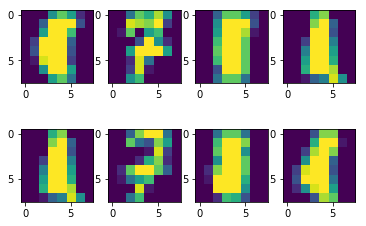

In [22]:
train_x, train_y, test_x, test_y = create_dataset_binary(class0=1, class1=7)

In [23]:
# reshape input as image
train_x = np.reshape(train_x, [len(train_y), 8, 8])
print('train_x shape', train_x.shape)
test_x = np.reshape(test_x, [len(test_y), 8, 8])
print('test_x shape', test_x.shape)

train_x shape (325, 8, 8)
test_x shape (36, 8, 8)


In [24]:
# we will make matrixes now and feed them into QCNN
train_x = np.array([make_matrixes_4x4(x, 8) for x in train_x])
print(train_x.shape)
test_x = np.array([make_matrixes_4x4(x, 8) for x in test_x])
print(test_x.shape)

(325, 9, 16)
(36, 9, 16)


In [25]:
lr = 0.0015
# steps = [10, 30, 50, 70, 100, 200, 300] #, 500, 700, 1000]
steps = [i for i in range(10, 811, 50)]
# steps = np.arange(500, 501, 10)
print(steps)
batch_size = 2

test_acc, test_loss = [], []
train_acc, train_loss = [], []

hyperparams = {'circuit': circuit,
               'task': 'supervised',
               'loss': myloss,
               'optimizer': 'Adam',
               'init_learning_rate': lr,
               'log_every': 1,
               'warm_start': False}

for step in steps:

    learner = CircuitLearner(hyperparams=hyperparams)

    learner.train_circuit(X=train_x, Y=train_y, steps=step, batch_size=batch_size)

    test_score = learner.score_circuit(X=test_x, Y=test_y,
                                       outputs_to_predictions=outputs_to_predictions)

    test_acc.append(test_score['accuracy'])
    test_loss.append(test_score['loss'])

    train_score = learner.score_circuit(X=train_x, Y=train_y,
                                       outputs_to_predictions=outputs_to_predictions)

    train_acc.append(train_score['accuracy'])
    train_loss.append(train_score['loss'])

[10, 60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610, 660, 710, 760, 810]

----------------------------- 
 HYPERPARAMETERS: 

batch_size - None (default value)
circuit - User defined function.
decay - 0.0 (default value)
init_learning_rate - 0.0015
log_every - 1
loss - User defined function.
model_dir - None (default value)
optimizer - Adam
outputs_to_predictions - None (default value)
plot_every - 1 (default value)
print_log - True (default value)
regularization_strength - 0.1 (default value)
regularizer - No regularizer provided.
task - supervised
warm_start - False

 -----------------------------
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': 'worker', '_service': None, '_model_dir': 'logsAUTO', '_log_step_count_steps': 100, '_num_worker_replicas': 1, '_keep_checkpoint_max': 5, '_global_id_in_cluster': 0, '_save_checkpoints_steps': None, '_session_config': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object a

INFO:tensorflow:Regularization = 0.0, Loss = 0.19431013, Cost = 0.19431013, Step = 33 (0.364 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.31051785, Cost = 0.31051785, Step = 34 (0.380 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2518435, Cost = 0.2518435, Step = 35 (0.331 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25394237, Cost = 0.25394237, Step = 36 (0.375 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.28817314, Cost = 0.28817314, Step = 37 (0.390 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1617451, Cost = 0.1617451, Step = 38 (0.354 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21171057, Cost = 0.21171057, Step = 39 (0.352 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20405935, Cost = 0.20405935, Step = 40 (0.386 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27265343, Cost = 0.27265343, Step = 41 (0.392 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20241973, Cost = 0.20241973, Step = 42 (0.360 sec)
INFO:tensorflow:Regulari

INFO:tensorflow:Regularization = 0.0, Loss = 0.23618174, Cost = 0.23618174, Step = 31 (0.353 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2443468, Cost = 0.2443468, Step = 32 (0.358 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19431013, Cost = 0.19431013, Step = 33 (0.352 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.31051785, Cost = 0.31051785, Step = 34 (0.371 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2518435, Cost = 0.2518435, Step = 35 (0.349 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25394237, Cost = 0.25394237, Step = 36 (0.370 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.28817314, Cost = 0.28817314, Step = 37 (0.375 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1617451, Cost = 0.1617451, Step = 38 (0.364 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21171057, Cost = 0.21171057, Step = 39 (0.379 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20405935, Cost = 0.20405935, Step = 40 (0.339 sec)
INFO:tensorflow:Regulariza

INFO:tensorflow:Restoring parameters from logsAUTO/model.ckpt-110
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2023-05-14-06:39:47
INFO:tensorflow:Saving dict for global step 110: accuracy = 0.5, global_step = 110, loss = 0.25008655
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-05-14-06:40:00
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from logsAUTO/model.ckpt-110
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2023-05-14-06:40:24
INFO:tensorflow:Saving dict for global step 110: accuracy = 0.6615385, global_step = 110, loss = 0.22355522

----------------------------- 
 HYPERPARAMETERS: 

batch_size - 325
circuit - User defined function.
decay - 0.0
init_learning_rate - 0.00

INFO:tensorflow:Regularization = 0.0, Loss = 0.25493687, Cost = 0.25493687, Step = 62 (0.359 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.31332442, Cost = 0.31332442, Step = 63 (0.339 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21866855, Cost = 0.21866855, Step = 64 (0.388 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21612017, Cost = 0.21612017, Step = 65 (0.353 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24560821, Cost = 0.24560821, Step = 66 (0.344 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23355083, Cost = 0.23355083, Step = 67 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22347558, Cost = 0.22347558, Step = 68 (0.342 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19200106, Cost = 0.19200106, Step = 69 (0.366 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18410304, Cost = 0.18410304, Step = 70 (0.361 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2281419, Cost = 0.2281419, Step = 71 (0.357 sec)
INFO:tensorflow:Regula

INFO:tensorflow:Regularization = 0.0, Loss = 0.1862954, Cost = 0.1862954, Step = 145 (0.379 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23827052, Cost = 0.23827052, Step = 146 (0.355 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.12190193, Cost = 0.12190193, Step = 147 (0.350 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11334259, Cost = 0.11334259, Step = 148 (0.354 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21899697, Cost = 0.21899697, Step = 149 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1967602, Cost = 0.1967602, Step = 150 (0.380 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19350266, Cost = 0.19350266, Step = 151 (0.371 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15508997, Cost = 0.15508997, Step = 152 (0.350 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18315698, Cost = 0.18315698, Step = 153 (0.383 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21874212, Cost = 0.21874212, Step = 154 (0.367 sec)
INFO:tensorflo

INFO:tensorflow:Regularization = 0.0, Loss = 0.25303906, Cost = 0.25303906, Step = 43 (0.357 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20638874, Cost = 0.20638874, Step = 44 (0.381 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2265294, Cost = 0.2265294, Step = 45 (0.361 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21263725, Cost = 0.21263725, Step = 46 (0.365 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2508458, Cost = 0.2508458, Step = 47 (0.344 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2424783, Cost = 0.2424783, Step = 48 (0.334 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18437256, Cost = 0.18437256, Step = 49 (0.363 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2062983, Cost = 0.2062983, Step = 50 (0.386 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2421968, Cost = 0.2421968, Step = 51 (0.380 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24632609, Cost = 0.24632609, Step = 52 (0.381 sec)
INFO:tensorflow:Regularization

INFO:tensorflow:Regularization = 0.0, Loss = 0.3394707, Cost = 0.3394707, Step = 126 (0.372 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23868397, Cost = 0.23868397, Step = 127 (0.355 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25100547, Cost = 0.25100547, Step = 128 (0.379 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22577879, Cost = 0.22577879, Step = 129 (0.367 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.26099813, Cost = 0.26099813, Step = 130 (0.378 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21053538, Cost = 0.21053538, Step = 131 (0.367 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23737715, Cost = 0.23737715, Step = 132 (0.372 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15808147, Cost = 0.15808147, Step = 133 (0.366 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.32784665, Cost = 0.32784665, Step = 134 (0.354 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16945626, Cost = 0.16945626, Step = 135 (0.357 sec)
INFO:tensorf

INFO:tensorflow:Regularization = 0.0, Loss = 0.13246392, Cost = 0.13246392, Step = 208 (0.358 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.28810382, Cost = 0.28810382, Step = 209 (0.364 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16602752, Cost = 0.16602752, Step = 210 (0.367 sec)
INFO:tensorflow:Saving checkpoints for 210 into logsAUTO/model.ckpt.
INFO:tensorflow:Loss for final step: 0.16602752.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-05-14-06:51:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from logsAUTO/model.ckpt-210
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2023-05-14-06:51:34
INFO:tensorflow:Saving dict for global step 210: accuracy = 0.6666667, global_step = 210, loss = 0.19927138
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling mode

INFO:tensorflow:Regularization = 0.0, Loss = 0.19752006, Cost = 0.19752006, Step = 56 (0.346 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24984829, Cost = 0.24984829, Step = 57 (0.376 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23195003, Cost = 0.23195003, Step = 58 (0.387 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2686788, Cost = 0.2686788, Step = 59 (0.343 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21937308, Cost = 0.21937308, Step = 60 (0.367 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.30397663, Cost = 0.30397663, Step = 61 (0.364 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25493687, Cost = 0.25493687, Step = 62 (0.369 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.31332442, Cost = 0.31332442, Step = 63 (0.351 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21866855, Cost = 0.21866855, Step = 64 (0.391 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21612017, Cost = 0.21612017, Step = 65 (0.374 sec)
INFO:tensorflow:Regula

INFO:tensorflow:Regularization = 0.0, Loss = 0.17461884, Cost = 0.17461884, Step = 139 (0.375 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.10260774, Cost = 0.10260774, Step = 140 (0.366 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23447292, Cost = 0.23447292, Step = 141 (0.384 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.31829453, Cost = 0.31829453, Step = 142 (0.379 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19171032, Cost = 0.19171032, Step = 143 (0.366 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20912391, Cost = 0.20912391, Step = 144 (0.343 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1862954, Cost = 0.1862954, Step = 145 (0.354 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23827052, Cost = 0.23827052, Step = 146 (0.350 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.12190193, Cost = 0.12190193, Step = 147 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11334259, Cost = 0.11334259, Step = 148 (0.380 sec)
INFO:tensorf

INFO:tensorflow:Regularization = 0.0, Loss = 0.16772708, Cost = 0.16772708, Step = 221 (0.363 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15097629, Cost = 0.15097629, Step = 222 (0.350 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20610815, Cost = 0.20610815, Step = 223 (0.390 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20516106, Cost = 0.20516106, Step = 224 (0.349 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2114341, Cost = 0.2114341, Step = 225 (0.333 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.103130266, Cost = 0.103130266, Step = 226 (0.366 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24051902, Cost = 0.24051902, Step = 227 (0.370 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.32193965, Cost = 0.32193965, Step = 228 (0.332 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22106498, Cost = 0.22106498, Step = 229 (0.364 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.28990078, Cost = 0.28990078, Step = 230 (0.372 sec)
INFO:tenso

INFO:tensorflow:Regularization = 0.0, Loss = 0.17123437, Cost = 0.17123437, Step = 19 (0.352 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20886055, Cost = 0.20886055, Step = 20 (0.361 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3075928, Cost = 0.3075928, Step = 21 (0.352 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.33316058, Cost = 0.33316058, Step = 22 (0.332 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24839361, Cost = 0.24839361, Step = 23 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25575653, Cost = 0.25575653, Step = 24 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22278647, Cost = 0.22278647, Step = 25 (0.378 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.262666, Cost = 0.262666, Step = 26 (0.386 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25977176, Cost = 0.25977176, Step = 27 (0.356 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18538395, Cost = 0.18538395, Step = 28 (0.383 sec)
INFO:tensorflow:Regulariza

INFO:tensorflow:Regularization = 0.0, Loss = 0.22334804, Cost = 0.22334804, Step = 102 (0.372 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2178773, Cost = 0.2178773, Step = 103 (0.370 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22240931, Cost = 0.22240931, Step = 104 (0.357 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27861264, Cost = 0.27861264, Step = 105 (0.361 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22416827, Cost = 0.22416827, Step = 106 (0.376 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23445556, Cost = 0.23445556, Step = 107 (0.363 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16907203, Cost = 0.16907203, Step = 108 (0.351 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.14871168, Cost = 0.14871168, Step = 109 (0.336 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.247969, Cost = 0.247969, Step = 110 (0.363 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.28977323, Cost = 0.28977323, Step = 111 (0.376 sec)
INFO:tensorflow:

INFO:tensorflow:Regularization = 0.0, Loss = 0.2684898, Cost = 0.2684898, Step = 186 (0.391 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.056637276, Cost = 0.056637276, Step = 187 (0.361 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23733664, Cost = 0.23733664, Step = 188 (0.376 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.34911355, Cost = 0.34911355, Step = 189 (0.380 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15156399, Cost = 0.15156399, Step = 190 (0.370 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3526373, Cost = 0.3526373, Step = 191 (0.334 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.12389359, Cost = 0.12389359, Step = 192 (0.377 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23385689, Cost = 0.23385689, Step = 193 (0.378 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19301635, Cost = 0.19301635, Step = 194 (0.369 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16408227, Cost = 0.16408227, Step = 195 (0.371 sec)
INFO:tensorf

INFO:tensorflow:Regularization = 0.0, Loss = 0.17061754, Cost = 0.17061754, Step = 268 (0.348 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.29226652, Cost = 0.29226652, Step = 269 (0.382 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19106367, Cost = 0.19106367, Step = 270 (0.353 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.10101663, Cost = 0.10101663, Step = 271 (0.353 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2009802, Cost = 0.2009802, Step = 272 (0.358 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19410738, Cost = 0.19410738, Step = 273 (0.343 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27259213, Cost = 0.27259213, Step = 274 (0.355 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18353176, Cost = 0.18353176, Step = 275 (0.354 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22210734, Cost = 0.22210734, Step = 276 (0.369 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1019005, Cost = 0.1019005, Step = 277 (0.374 sec)
INFO:tensorflo

INFO:tensorflow:Regularization = 0.0, Loss = 0.237804, Cost = 0.237804, Step = 15 (0.390 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2377091, Cost = 0.2377091, Step = 16 (0.338 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15676296, Cost = 0.15676296, Step = 17 (0.384 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.33620715, Cost = 0.33620715, Step = 18 (0.385 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17123437, Cost = 0.17123437, Step = 19 (0.361 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20886055, Cost = 0.20886055, Step = 20 (0.374 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3075928, Cost = 0.3075928, Step = 21 (0.363 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.33316058, Cost = 0.33316058, Step = 22 (0.373 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24839361, Cost = 0.24839361, Step = 23 (0.375 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25575653, Cost = 0.25575653, Step = 24 (0.362 sec)
INFO:tensorflow:Regularizati

INFO:tensorflow:Regularization = 0.0, Loss = 0.22288406, Cost = 0.22288406, Step = 100 (0.378 sec)
INFO:tensorflow:global_step/sec: 2.20758
INFO:tensorflow:Regularization = 0.0, Loss = 0.28154507, Cost = 0.28154507, Step = 101 (0.399 sec)
INFO:tensorflow:loss = 0.28154507, step = 101 (45.304 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22334804, Cost = 0.22334804, Step = 102 (0.378 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2178773, Cost = 0.2178773, Step = 103 (0.366 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22240931, Cost = 0.22240931, Step = 104 (0.370 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27861264, Cost = 0.27861264, Step = 105 (0.354 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22416827, Cost = 0.22416827, Step = 106 (0.365 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23445556, Cost = 0.23445556, Step = 107 (0.358 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16907203, Cost = 0.16907203, Step = 108 (0.379 sec)
INFO:tensor

INFO:tensorflow:Regularization = 0.0, Loss = 0.23202609, Cost = 0.23202609, Step = 183 (0.373 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.13042076, Cost = 0.13042076, Step = 184 (0.374 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1631639, Cost = 0.1631639, Step = 185 (0.350 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2684898, Cost = 0.2684898, Step = 186 (0.372 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.056637276, Cost = 0.056637276, Step = 187 (0.344 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23733664, Cost = 0.23733664, Step = 188 (0.351 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.34911355, Cost = 0.34911355, Step = 189 (0.363 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15156399, Cost = 0.15156399, Step = 190 (0.376 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3526373, Cost = 0.3526373, Step = 191 (0.349 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.12389359, Cost = 0.12389359, Step = 192 (0.356 sec)
INFO:tensorflo

INFO:tensorflow:Regularization = 0.0, Loss = 0.061670292, Cost = 0.061670292, Step = 265 (0.382 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.13054997, Cost = 0.13054997, Step = 266 (0.351 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.5294079, Cost = 0.5294079, Step = 267 (0.355 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17061754, Cost = 0.17061754, Step = 268 (0.347 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.29226652, Cost = 0.29226652, Step = 269 (0.365 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19106367, Cost = 0.19106367, Step = 270 (0.381 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.10101663, Cost = 0.10101663, Step = 271 (0.345 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2009802, Cost = 0.2009802, Step = 272 (0.371 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19410738, Cost = 0.19410738, Step = 273 (0.368 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27259213, Cost = 0.27259213, Step = 274 (0.343 sec)
INFO:tensorf

INFO:tensorflow:Regularization = 0.0, Loss = 0.051504385, Cost = 0.051504385, Step = 348 (0.376 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2895175, Cost = 0.2895175, Step = 349 (0.382 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16403812, Cost = 0.16403812, Step = 350 (0.386 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2760308, Cost = 0.2760308, Step = 351 (0.369 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.262283, Cost = 0.262283, Step = 352 (0.362 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3902943, Cost = 0.3902943, Step = 353 (0.363 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.31735772, Cost = 0.31735772, Step = 354 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.12051885, Cost = 0.12051885, Step = 355 (0.344 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19161545, Cost = 0.19161545, Step = 356 (0.361 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22540352, Cost = 0.22540352, Step = 357 (0.323 sec)
INFO:tensorflow:Re

INFO:tensorflow:Regularization = 0.0, Loss = 0.21263725, Cost = 0.21263725, Step = 46 (0.389 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2508458, Cost = 0.2508458, Step = 47 (0.362 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2424783, Cost = 0.2424783, Step = 48 (0.384 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18437256, Cost = 0.18437256, Step = 49 (0.359 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2062983, Cost = 0.2062983, Step = 50 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2421968, Cost = 0.2421968, Step = 51 (0.359 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24632609, Cost = 0.24632609, Step = 52 (0.354 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.26612693, Cost = 0.26612693, Step = 53 (0.351 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2576095, Cost = 0.2576095, Step = 54 (0.369 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21569744, Cost = 0.21569744, Step = 55 (0.367 sec)
INFO:tensorflow:Regularization

INFO:tensorflow:Regularization = 0.0, Loss = 0.22577879, Cost = 0.22577879, Step = 129 (0.368 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.26099813, Cost = 0.26099813, Step = 130 (0.364 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21053538, Cost = 0.21053538, Step = 131 (0.375 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23737715, Cost = 0.23737715, Step = 132 (0.367 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15808147, Cost = 0.15808147, Step = 133 (0.372 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.32784665, Cost = 0.32784665, Step = 134 (0.358 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16945626, Cost = 0.16945626, Step = 135 (0.350 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23866242, Cost = 0.23866242, Step = 136 (0.345 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16501984, Cost = 0.16501984, Step = 137 (0.364 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18221179, Cost = 0.18221179, Step = 138 (0.369 sec)
INFO:tenso

INFO:tensorflow:Regularization = 0.0, Loss = 0.09011361, Cost = 0.09011361, Step = 211 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.032833286, Cost = 0.032833286, Step = 212 (0.378 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21670847, Cost = 0.21670847, Step = 213 (0.356 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.33705837, Cost = 0.33705837, Step = 214 (0.380 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20057333, Cost = 0.20057333, Step = 215 (0.376 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2561343, Cost = 0.2561343, Step = 216 (0.356 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1096686, Cost = 0.1096686, Step = 217 (0.370 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.13426557, Cost = 0.13426557, Step = 218 (0.369 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.03547548, Cost = 0.03547548, Step = 219 (0.377 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3770675, Cost = 0.3770675, Step = 220 (0.366 sec)
INFO:tensorflo

INFO:tensorflow:Regularization = 0.0, Loss = 0.11791241, Cost = 0.11791241, Step = 294 (0.345 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19807827, Cost = 0.19807827, Step = 295 (0.367 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16547386, Cost = 0.16547386, Step = 296 (0.392 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2188873, Cost = 0.2188873, Step = 297 (0.355 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19675462, Cost = 0.19675462, Step = 298 (0.388 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18044543, Cost = 0.18044543, Step = 299 (0.388 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.07852236, Cost = 0.07852236, Step = 300 (0.332 sec)
INFO:tensorflow:global_step/sec: 2.72895
INFO:tensorflow:Regularization = 0.0, Loss = 0.1645487, Cost = 0.1645487, Step = 301 (0.369 sec)
INFO:tensorflow:loss = 0.1645487, step = 301 (36.644 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.09678404, Cost = 0.09678404, Step = 302 (0.394 sec)
INFO:tensorflo

INFO:tensorflow:Regularization = 0.0, Loss = 0.29135895, Cost = 0.29135895, Step = 377 (0.368 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2737691, Cost = 0.2737691, Step = 378 (0.366 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.12338109, Cost = 0.12338109, Step = 379 (0.379 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.13828468, Cost = 0.13828468, Step = 380 (0.375 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.05965224, Cost = 0.05965224, Step = 381 (0.373 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19128837, Cost = 0.19128837, Step = 382 (0.369 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2830723, Cost = 0.2830723, Step = 383 (0.335 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16572237, Cost = 0.16572237, Step = 384 (0.350 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.14619371, Cost = 0.14619371, Step = 385 (0.381 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2247747, Cost = 0.2247747, Step = 386 (0.364 sec)
INFO:tensorflow:

INFO:tensorflow:Regularization = 0.0, Loss = 0.25575653, Cost = 0.25575653, Step = 24 (0.362 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22278647, Cost = 0.22278647, Step = 25 (0.387 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.262666, Cost = 0.262666, Step = 26 (0.367 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25977176, Cost = 0.25977176, Step = 27 (0.379 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18538395, Cost = 0.18538395, Step = 28 (0.357 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17568219, Cost = 0.17568219, Step = 29 (0.375 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3274312, Cost = 0.3274312, Step = 30 (0.371 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23618174, Cost = 0.23618174, Step = 31 (0.366 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2443468, Cost = 0.2443468, Step = 32 (0.355 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19431013, Cost = 0.19431013, Step = 33 (0.358 sec)
INFO:tensorflow:Regularizati

INFO:tensorflow:Regularization = 0.0, Loss = 0.23445556, Cost = 0.23445556, Step = 107 (0.402 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16907203, Cost = 0.16907203, Step = 108 (0.335 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.14871168, Cost = 0.14871168, Step = 109 (0.373 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.247969, Cost = 0.247969, Step = 110 (0.357 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.28977323, Cost = 0.28977323, Step = 111 (0.352 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25863153, Cost = 0.25863153, Step = 112 (0.362 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25609004, Cost = 0.25609004, Step = 113 (0.371 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27734292, Cost = 0.27734292, Step = 114 (0.363 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3367334, Cost = 0.3367334, Step = 115 (0.367 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.12845707, Cost = 0.12845707, Step = 116 (0.371 sec)
INFO:tensorflow:

INFO:tensorflow:Regularization = 0.0, Loss = 0.3526373, Cost = 0.3526373, Step = 191 (0.380 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.12389359, Cost = 0.12389359, Step = 192 (0.340 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23385689, Cost = 0.23385689, Step = 193 (0.375 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19301635, Cost = 0.19301635, Step = 194 (0.343 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16408227, Cost = 0.16408227, Step = 195 (0.343 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25843138, Cost = 0.25843138, Step = 196 (0.355 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19857171, Cost = 0.19857171, Step = 197 (0.383 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.119656265, Cost = 0.119656265, Step = 198 (0.372 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.4522772, Cost = 0.4522772, Step = 199 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23962805, Cost = 0.23962805, Step = 200 (0.373 sec)
INFO:tensorf

INFO:tensorflow:Regularization = 0.0, Loss = 0.19410738, Cost = 0.19410738, Step = 273 (0.378 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27259213, Cost = 0.27259213, Step = 274 (0.380 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18353176, Cost = 0.18353176, Step = 275 (0.386 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22210734, Cost = 0.22210734, Step = 276 (0.365 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1019005, Cost = 0.1019005, Step = 277 (0.384 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.07760419, Cost = 0.07760419, Step = 278 (0.370 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2505927, Cost = 0.2505927, Step = 279 (0.356 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2815803, Cost = 0.2815803, Step = 280 (0.372 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.13480622, Cost = 0.13480622, Step = 281 (0.365 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20698269, Cost = 0.20698269, Step = 282 (0.362 sec)
INFO:tensorflow:

INFO:tensorflow:Regularization = 0.0, Loss = 0.19161545, Cost = 0.19161545, Step = 356 (0.369 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22540352, Cost = 0.22540352, Step = 357 (0.380 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24687926, Cost = 0.24687926, Step = 358 (0.375 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.13945179, Cost = 0.13945179, Step = 359 (0.350 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1500318, Cost = 0.1500318, Step = 360 (0.382 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21626036, Cost = 0.21626036, Step = 361 (0.368 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.42306906, Cost = 0.42306906, Step = 362 (0.353 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.13405938, Cost = 0.13405938, Step = 363 (0.376 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.14933383, Cost = 0.14933383, Step = 364 (0.344 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11685356, Cost = 0.11685356, Step = 365 (0.374 sec)
INFO:tensorf

INFO:tensorflow:Regularization = 0.0, Loss = 0.23623085, Cost = 0.23623085, Step = 438 (0.368 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.132191, Cost = 0.132191, Step = 439 (0.356 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.04967101, Cost = 0.04967101, Step = 440 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2240196, Cost = 0.2240196, Step = 441 (0.339 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23870747, Cost = 0.23870747, Step = 442 (0.387 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2658505, Cost = 0.2658505, Step = 443 (0.345 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19233678, Cost = 0.19233678, Step = 444 (0.359 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2638566, Cost = 0.2638566, Step = 445 (0.364 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22897252, Cost = 0.22897252, Step = 446 (0.321 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20482115, Cost = 0.20482115, Step = 447 (0.378 sec)
INFO:tensorflow:Regu

INFO:tensorflow:Regularization = 0.0, Loss = 0.25394237, Cost = 0.25394237, Step = 36 (0.352 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.28817314, Cost = 0.28817314, Step = 37 (0.380 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1617451, Cost = 0.1617451, Step = 38 (0.376 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21171057, Cost = 0.21171057, Step = 39 (0.377 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20405935, Cost = 0.20405935, Step = 40 (0.392 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27265343, Cost = 0.27265343, Step = 41 (0.365 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20241973, Cost = 0.20241973, Step = 42 (0.367 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25303906, Cost = 0.25303906, Step = 43 (0.372 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20638874, Cost = 0.20638874, Step = 44 (0.389 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2265294, Cost = 0.2265294, Step = 45 (0.367 sec)
INFO:tensorflow:Regulari

INFO:tensorflow:Regularization = 0.0, Loss = 0.2327193, Cost = 0.2327193, Step = 119 (0.351 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.26686913, Cost = 0.26686913, Step = 120 (0.371 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21762604, Cost = 0.21762604, Step = 121 (0.392 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17998998, Cost = 0.17998998, Step = 122 (0.378 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.12609859, Cost = 0.12609859, Step = 123 (0.363 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.284044, Cost = 0.284044, Step = 124 (0.350 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.29857913, Cost = 0.29857913, Step = 125 (0.320 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3394707, Cost = 0.3394707, Step = 126 (0.370 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23868397, Cost = 0.23868397, Step = 127 (0.392 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25100547, Cost = 0.25100547, Step = 128 (0.376 sec)
INFO:tensorflow:Re

INFO:tensorflow:loss = 0.16944224, step = 201 (36.391 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.10618928, Cost = 0.10618928, Step = 202 (0.395 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11951331, Cost = 0.11951331, Step = 203 (0.395 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.33337384, Cost = 0.33337384, Step = 204 (0.364 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18490271, Cost = 0.18490271, Step = 205 (0.383 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18930167, Cost = 0.18930167, Step = 206 (0.366 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.13198516, Cost = 0.13198516, Step = 207 (0.357 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.13246392, Cost = 0.13246392, Step = 208 (0.344 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.28810382, Cost = 0.28810382, Step = 209 (0.352 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16602752, Cost = 0.16602752, Step = 210 (0.358 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.090

INFO:tensorflow:Regularization = 0.0, Loss = 0.14485879, Cost = 0.14485879, Step = 285 (0.391 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15042642, Cost = 0.15042642, Step = 286 (0.383 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23877062, Cost = 0.23877062, Step = 287 (0.364 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.4478, Cost = 0.4478, Step = 288 (0.353 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21962221, Cost = 0.21962221, Step = 289 (0.394 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18038006, Cost = 0.18038006, Step = 290 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22341463, Cost = 0.22341463, Step = 291 (0.369 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17453668, Cost = 0.17453668, Step = 292 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.38942474, Cost = 0.38942474, Step = 293 (0.361 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11791241, Cost = 0.11791241, Step = 294 (0.376 sec)
INFO:tensorflow:Re

INFO:tensorflow:Regularization = 0.0, Loss = 0.13501418, Cost = 0.13501418, Step = 368 (0.373 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15968372, Cost = 0.15968372, Step = 369 (0.361 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15781309, Cost = 0.15781309, Step = 370 (0.349 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19488099, Cost = 0.19488099, Step = 371 (0.365 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.34381485, Cost = 0.34381485, Step = 372 (0.362 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1124643, Cost = 0.1124643, Step = 373 (0.352 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.04592142, Cost = 0.04592142, Step = 374 (0.363 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15276548, Cost = 0.15276548, Step = 375 (0.332 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.123003304, Cost = 0.123003304, Step = 376 (0.352 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.29135895, Cost = 0.29135895, Step = 377 (0.367 sec)
INFO:tenso

INFO:tensorflow:Regularization = 0.0, Loss = 0.29667595, Cost = 0.29667595, Step = 450 (0.368 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.42210704, Cost = 0.42210704, Step = 451 (0.365 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.06239242, Cost = 0.06239242, Step = 452 (0.370 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22198221, Cost = 0.22198221, Step = 453 (0.371 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21792902, Cost = 0.21792902, Step = 454 (0.352 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3181227, Cost = 0.3181227, Step = 455 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.09310517, Cost = 0.09310517, Step = 456 (0.361 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19399923, Cost = 0.19399923, Step = 457 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1052983, Cost = 0.1052983, Step = 458 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19578953, Cost = 0.19578953, Step = 459 (0.363 sec)
INFO:tensorflo

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into logsAUTO/model.ckpt.
INFO:tensorflow:Regularization = 0.0, Loss = 0.26506886, Cost = 0.26506886, Step = 1
INFO:tensorflow:loss = 0.26506886, step = 1
INFO:tensorflow:Regularization = 0.0, Loss = 0.18236655, Cost = 0.18236655, Step = 2 (8.932 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.33605438, Cost = 0.33605438, Step = 3 (0.349 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.26201046, Cost = 0.26201046, Step = 4 (0.351 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1696192, Cost = 0.1696192, Step = 5 (0.336 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.33539456, Cost = 0.33539456, Step = 6 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24910358, Cost = 0.24910358, Step = 7

INFO:tensorflow:Regularization = 0.0, Loss = 0.35211152, Cost = 0.35211152, Step = 82 (0.381 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.41810632, Cost = 0.41810632, Step = 83 (0.365 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27228844, Cost = 0.27228844, Step = 84 (0.359 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24627215, Cost = 0.24627215, Step = 85 (0.357 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.29701588, Cost = 0.29701588, Step = 86 (0.354 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17611557, Cost = 0.17611557, Step = 87 (0.362 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19948474, Cost = 0.19948474, Step = 88 (0.350 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21230668, Cost = 0.21230668, Step = 89 (0.343 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2500346, Cost = 0.2500346, Step = 90 (0.355 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25228453, Cost = 0.25228453, Step = 91 (0.356 sec)
INFO:tensorflow:Regula

INFO:tensorflow:Regularization = 0.0, Loss = 0.22823197, Cost = 0.22823197, Step = 165 (0.361 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11253196, Cost = 0.11253196, Step = 166 (0.371 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25949007, Cost = 0.25949007, Step = 167 (0.365 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15881613, Cost = 0.15881613, Step = 168 (0.372 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18704616, Cost = 0.18704616, Step = 169 (0.374 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24917057, Cost = 0.24917057, Step = 170 (0.361 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.09771626, Cost = 0.09771626, Step = 171 (0.362 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22011945, Cost = 0.22011945, Step = 172 (0.365 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11575827, Cost = 0.11575827, Step = 173 (0.359 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27345666, Cost = 0.27345666, Step = 174 (0.337 sec)
INFO:tenso

INFO:tensorflow:Regularization = 0.0, Loss = 0.28290266, Cost = 0.28290266, Step = 247 (0.388 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24742371, Cost = 0.24742371, Step = 248 (0.352 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1048615, Cost = 0.1048615, Step = 249 (0.375 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18682471, Cost = 0.18682471, Step = 250 (0.355 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.29061896, Cost = 0.29061896, Step = 251 (0.377 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17834084, Cost = 0.17834084, Step = 252 (0.346 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.14477053, Cost = 0.14477053, Step = 253 (0.334 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2467348, Cost = 0.2467348, Step = 254 (0.383 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23886412, Cost = 0.23886412, Step = 255 (0.340 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.124999486, Cost = 0.124999486, Step = 256 (0.382 sec)
INFO:tensorf

INFO:tensorflow:Regularization = 0.0, Loss = 0.22834203, Cost = 0.22834203, Step = 330 (0.344 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17503989, Cost = 0.17503989, Step = 331 (0.355 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11521715, Cost = 0.11521715, Step = 332 (0.372 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19744217, Cost = 0.19744217, Step = 333 (0.387 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.030225717, Cost = 0.030225717, Step = 334 (0.385 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.26158053, Cost = 0.26158053, Step = 335 (0.369 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18760014, Cost = 0.18760014, Step = 336 (0.381 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21662882, Cost = 0.21662882, Step = 337 (0.376 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.104609266, Cost = 0.104609266, Step = 338 (0.376 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2307208, Cost = 0.2307208, Step = 339 (0.357 sec)
INFO:ten

INFO:tensorflow:Regularization = 0.0, Loss = 0.094956025, Cost = 0.094956025, Step = 412 (0.366 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20173344, Cost = 0.20173344, Step = 413 (0.370 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20765851, Cost = 0.20765851, Step = 414 (0.348 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21118566, Cost = 0.21118566, Step = 415 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1518342, Cost = 0.1518342, Step = 416 (0.346 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19889018, Cost = 0.19889018, Step = 417 (0.370 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21938756, Cost = 0.21938756, Step = 418 (0.368 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.116530985, Cost = 0.116530985, Step = 419 (0.391 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11695794, Cost = 0.11695794, Step = 420 (0.351 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.09033054, Cost = 0.09033054, Step = 421 (0.375 sec)
INFO:ten

INFO:tensorflow:Regularization = 0.0, Loss = 0.20703831, Cost = 0.20703831, Step = 495 (0.329 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.011181852, Cost = 0.011181852, Step = 496 (0.377 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.26383835, Cost = 0.26383835, Step = 497 (0.379 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.039100237, Cost = 0.039100237, Step = 498 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24145068, Cost = 0.24145068, Step = 499 (0.364 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20502508, Cost = 0.20502508, Step = 500 (0.381 sec)
INFO:tensorflow:global_step/sec: 2.70529
INFO:tensorflow:Regularization = 0.0, Loss = 0.06131181, Cost = 0.06131181, Step = 501 (0.372 sec)
INFO:tensorflow:loss = 0.06131181, step = 501 (36.964 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17454092, Cost = 0.17454092, Step = 502 (0.381 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1317861, Cost = 0.1317861, Step = 503 (0.373 sec)
INFO:te

INFO:tensorflow:Using config: {'_task_type': 'worker', '_service': None, '_model_dir': 'logsAUTO', '_log_step_count_steps': 100, '_num_worker_replicas': 1, '_keep_checkpoint_max': 5, '_global_id_in_cluster': 0, '_save_checkpoints_steps': None, '_session_config': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa7c397f2b0>, '_save_summary_steps': 100, '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_evaluation_master': '', '_save_checkpoints_secs': 600, '_tf_random_seed': None, '_keep_checkpoint_every_n_hours': 10000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into logsAUTO/model.ckpt.
INFO:tensorflow:Regularization = 0.0, Loss = 0.26506886, Cost = 0.26506886, Step = 1
INFO:tensorflow:loss = 0

INFO:tensorflow:Regularization = 0.0, Loss = 0.23614337, Cost = 0.23614337, Step = 76 (0.379 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25049996, Cost = 0.25049996, Step = 77 (0.374 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1842241, Cost = 0.1842241, Step = 78 (0.388 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16038078, Cost = 0.16038078, Step = 79 (0.352 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15803824, Cost = 0.15803824, Step = 80 (0.395 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2512654, Cost = 0.2512654, Step = 81 (0.377 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.35211152, Cost = 0.35211152, Step = 82 (0.368 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.41810632, Cost = 0.41810632, Step = 83 (0.369 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27228844, Cost = 0.27228844, Step = 84 (0.368 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24627215, Cost = 0.24627215, Step = 85 (0.379 sec)
INFO:tensorflow:Regulari

INFO:tensorflow:Regularization = 0.0, Loss = 0.2363083, Cost = 0.2363083, Step = 159 (0.384 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.09993078, Cost = 0.09993078, Step = 160 (0.361 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.28575203, Cost = 0.28575203, Step = 161 (0.351 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22971305, Cost = 0.22971305, Step = 162 (0.335 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2792452, Cost = 0.2792452, Step = 163 (0.354 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15738918, Cost = 0.15738918, Step = 164 (0.389 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22823197, Cost = 0.22823197, Step = 165 (0.383 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11253196, Cost = 0.11253196, Step = 166 (0.347 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25949007, Cost = 0.25949007, Step = 167 (0.351 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15881613, Cost = 0.15881613, Step = 168 (0.386 sec)
INFO:tensorflo

INFO:tensorflow:Regularization = 0.0, Loss = 0.14604926, Cost = 0.14604926, Step = 241 (0.371 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.09390145, Cost = 0.09390145, Step = 242 (0.358 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16834454, Cost = 0.16834454, Step = 243 (0.348 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.4411136, Cost = 0.4411136, Step = 244 (0.391 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.43617463, Cost = 0.43617463, Step = 245 (0.385 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23301472, Cost = 0.23301472, Step = 246 (0.375 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.28290266, Cost = 0.28290266, Step = 247 (0.408 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24742371, Cost = 0.24742371, Step = 248 (0.344 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1048615, Cost = 0.1048615, Step = 249 (0.343 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18682471, Cost = 0.18682471, Step = 250 (0.363 sec)
INFO:tensorflo

INFO:tensorflow:Regularization = 0.0, Loss = 0.12749323, Cost = 0.12749323, Step = 324 (0.390 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.123274215, Cost = 0.123274215, Step = 325 (0.382 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24607916, Cost = 0.24607916, Step = 326 (0.398 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1338703, Cost = 0.1338703, Step = 327 (0.362 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.14252445, Cost = 0.14252445, Step = 328 (0.378 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.035614777, Cost = 0.035614777, Step = 329 (0.388 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22834203, Cost = 0.22834203, Step = 330 (0.365 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17503989, Cost = 0.17503989, Step = 331 (0.364 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11521715, Cost = 0.11521715, Step = 332 (0.379 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19744217, Cost = 0.19744217, Step = 333 (0.361 sec)
INFO:ten

INFO:tensorflow:Regularization = 0.0, Loss = 0.24558172, Cost = 0.24558172, Step = 406 (0.376 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.4133723, Cost = 0.4133723, Step = 407 (0.353 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2453995, Cost = 0.2453995, Step = 408 (0.333 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24037588, Cost = 0.24037588, Step = 409 (0.365 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27208453, Cost = 0.27208453, Step = 410 (0.332 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.074363396, Cost = 0.074363396, Step = 411 (0.341 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.094956025, Cost = 0.094956025, Step = 412 (0.371 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20173344, Cost = 0.20173344, Step = 413 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20765851, Cost = 0.20765851, Step = 414 (0.374 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21118566, Cost = 0.21118566, Step = 415 (0.373 sec)
INFO:tenso

INFO:tensorflow:Regularization = 0.0, Loss = 0.105726846, Cost = 0.105726846, Step = 489 (0.386 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20246649, Cost = 0.20246649, Step = 490 (0.362 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.029608855, Cost = 0.029608855, Step = 491 (0.357 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21187158, Cost = 0.21187158, Step = 492 (0.329 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.091562726, Cost = 0.091562726, Step = 493 (0.356 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18252191, Cost = 0.18252191, Step = 494 (0.343 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20703831, Cost = 0.20703831, Step = 495 (0.343 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.011181852, Cost = 0.011181852, Step = 496 (0.389 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.26383835, Cost = 0.26383835, Step = 497 (0.394 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.039100237, Cost = 0.039100237, Step = 498 (0.354 sec)


INFO:tensorflow:Regularization = 0.0, Loss = 0.17492872, Cost = 0.17492872, Step = 571 (0.365 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.29642987, Cost = 0.29642987, Step = 572 (0.370 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.10132627, Cost = 0.10132627, Step = 573 (0.356 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.08913656, Cost = 0.08913656, Step = 574 (0.335 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21173853, Cost = 0.21173853, Step = 575 (0.362 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17534854, Cost = 0.17534854, Step = 576 (0.375 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15281574, Cost = 0.15281574, Step = 577 (0.369 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11840673, Cost = 0.11840673, Step = 578 (0.356 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19507319, Cost = 0.19507319, Step = 579 (0.400 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.14445068, Cost = 0.14445068, Step = 580 (0.361 sec)
INFO:tenso

INFO:tensorflow:Regularization = 0.0, Loss = 0.15676296, Cost = 0.15676296, Step = 17 (0.390 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.33620715, Cost = 0.33620715, Step = 18 (0.368 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17123437, Cost = 0.17123437, Step = 19 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20886055, Cost = 0.20886055, Step = 20 (0.370 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3075928, Cost = 0.3075928, Step = 21 (0.388 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.33316058, Cost = 0.33316058, Step = 22 (0.359 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24839361, Cost = 0.24839361, Step = 23 (0.367 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25575653, Cost = 0.25575653, Step = 24 (0.367 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22278647, Cost = 0.22278647, Step = 25 (0.370 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.262666, Cost = 0.262666, Step = 26 (0.380 sec)
INFO:tensorflow:Regulariza

INFO:tensorflow:global_step/sec: 2.1961
INFO:tensorflow:Regularization = 0.0, Loss = 0.28154507, Cost = 0.28154507, Step = 101 (0.398 sec)
INFO:tensorflow:loss = 0.28154507, step = 101 (45.543 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22334804, Cost = 0.22334804, Step = 102 (0.377 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2178773, Cost = 0.2178773, Step = 103 (0.376 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22240931, Cost = 0.22240931, Step = 104 (0.376 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27861264, Cost = 0.27861264, Step = 105 (0.353 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22416827, Cost = 0.22416827, Step = 106 (0.363 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23445556, Cost = 0.23445556, Step = 107 (0.368 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16907203, Cost = 0.16907203, Step = 108 (0.369 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.14871168, Cost = 0.14871168, Step = 109 (0.362 sec)
INFO:tensorf

INFO:tensorflow:Regularization = 0.0, Loss = 0.13042076, Cost = 0.13042076, Step = 184 (0.381 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1631639, Cost = 0.1631639, Step = 185 (0.397 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2684898, Cost = 0.2684898, Step = 186 (0.392 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.056637276, Cost = 0.056637276, Step = 187 (0.347 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23733664, Cost = 0.23733664, Step = 188 (0.375 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.34911355, Cost = 0.34911355, Step = 189 (0.377 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15156399, Cost = 0.15156399, Step = 190 (0.388 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3526373, Cost = 0.3526373, Step = 191 (0.355 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.12389359, Cost = 0.12389359, Step = 192 (0.387 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23385689, Cost = 0.23385689, Step = 193 (0.374 sec)
INFO:tensorflo

INFO:tensorflow:Regularization = 0.0, Loss = 0.13054997, Cost = 0.13054997, Step = 266 (0.337 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.5294079, Cost = 0.5294079, Step = 267 (0.373 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17061754, Cost = 0.17061754, Step = 268 (0.392 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.29226652, Cost = 0.29226652, Step = 269 (0.369 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19106367, Cost = 0.19106367, Step = 270 (0.354 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.10101663, Cost = 0.10101663, Step = 271 (0.374 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2009802, Cost = 0.2009802, Step = 272 (0.362 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19410738, Cost = 0.19410738, Step = 273 (0.371 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27259213, Cost = 0.27259213, Step = 274 (0.387 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18353176, Cost = 0.18353176, Step = 275 (0.394 sec)
INFO:tensorflo

INFO:tensorflow:Regularization = 0.0, Loss = 0.2895175, Cost = 0.2895175, Step = 349 (0.362 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16403812, Cost = 0.16403812, Step = 350 (0.357 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2760308, Cost = 0.2760308, Step = 351 (0.364 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.262283, Cost = 0.262283, Step = 352 (0.364 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3902943, Cost = 0.3902943, Step = 353 (0.364 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.31735772, Cost = 0.31735772, Step = 354 (0.343 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.12051885, Cost = 0.12051885, Step = 355 (0.372 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19161545, Cost = 0.19161545, Step = 356 (0.398 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22540352, Cost = 0.22540352, Step = 357 (0.388 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24687926, Cost = 0.24687926, Step = 358 (0.387 sec)
INFO:tensorflow:Regu

INFO:tensorflow:Regularization = 0.0, Loss = 0.31926915, Cost = 0.31926915, Step = 431 (0.344 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.42538255, Cost = 0.42538255, Step = 432 (0.371 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0386419, Cost = 0.0386419, Step = 433 (0.386 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.03069664, Cost = 0.03069664, Step = 434 (0.399 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11949335, Cost = 0.11949335, Step = 435 (0.379 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27003083, Cost = 0.27003083, Step = 436 (0.392 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18580215, Cost = 0.18580215, Step = 437 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23623085, Cost = 0.23623085, Step = 438 (0.366 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.132191, Cost = 0.132191, Step = 439 (0.372 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.04967101, Cost = 0.04967101, Step = 440 (0.391 sec)
INFO:tensorflow:

INFO:tensorflow:Regularization = 0.0, Loss = 0.24177502, Cost = 0.24177502, Step = 513 (0.382 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3520279, Cost = 0.3520279, Step = 514 (0.354 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19217354, Cost = 0.19217354, Step = 515 (0.358 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24960095, Cost = 0.24960095, Step = 516 (0.371 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1482773, Cost = 0.1482773, Step = 517 (0.369 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23132001, Cost = 0.23132001, Step = 518 (0.363 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17379853, Cost = 0.17379853, Step = 519 (0.373 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11332966, Cost = 0.11332966, Step = 520 (0.362 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24230516, Cost = 0.24230516, Step = 521 (0.397 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15394273, Cost = 0.15394273, Step = 522 (0.375 sec)
INFO:tensorflo

INFO:tensorflow:Regularization = 0.0, Loss = 0.032640297, Cost = 0.032640297, Step = 596 (0.376 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.102118105, Cost = 0.102118105, Step = 597 (0.364 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.12953487, Cost = 0.12953487, Step = 598 (0.374 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22252397, Cost = 0.22252397, Step = 599 (0.375 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18103656, Cost = 0.18103656, Step = 600 (0.352 sec)
INFO:tensorflow:global_step/sec: 2.74667
INFO:tensorflow:Regularization = 0.0, Loss = 0.20905921, Cost = 0.20905921, Step = 601 (0.398 sec)
INFO:tensorflow:loss = 0.20905921, step = 601 (36.414 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.084947065, Cost = 0.084947065, Step = 602 (0.370 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.05537124, Cost = 0.05537124, Step = 603 (0.372 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2679397, Cost = 0.2679397, Step = 604 (0.371 sec)
INFO:

INFO:tensorflow:Using config: {'_task_type': 'worker', '_service': None, '_model_dir': 'logsAUTO', '_log_step_count_steps': 100, '_num_worker_replicas': 1, '_keep_checkpoint_max': 5, '_global_id_in_cluster': 0, '_save_checkpoints_steps': None, '_session_config': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa7fba1acc0>, '_save_summary_steps': 100, '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_evaluation_master': '', '_save_checkpoints_secs': 600, '_tf_random_seed': None, '_keep_checkpoint_every_n_hours': 10000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into logsAUTO/model.ckpt.
INFO:tensorflow:Regularization = 0.0, Loss = 0.26506886, Cost = 0.26506886, Step = 1
INFO:tensorflow:loss = 0

INFO:tensorflow:Regularization = 0.0, Loss = 0.23614337, Cost = 0.23614337, Step = 76 (0.371 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25049996, Cost = 0.25049996, Step = 77 (0.383 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1842241, Cost = 0.1842241, Step = 78 (0.350 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16038078, Cost = 0.16038078, Step = 79 (0.369 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15803824, Cost = 0.15803824, Step = 80 (0.370 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2512654, Cost = 0.2512654, Step = 81 (0.390 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.35211152, Cost = 0.35211152, Step = 82 (0.383 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.41810632, Cost = 0.41810632, Step = 83 (0.367 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27228844, Cost = 0.27228844, Step = 84 (0.375 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24627215, Cost = 0.24627215, Step = 85 (0.391 sec)
INFO:tensorflow:Regulari

INFO:tensorflow:Regularization = 0.0, Loss = 0.2363083, Cost = 0.2363083, Step = 159 (0.373 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.09993078, Cost = 0.09993078, Step = 160 (0.394 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.28575203, Cost = 0.28575203, Step = 161 (0.396 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22971305, Cost = 0.22971305, Step = 162 (0.405 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2792452, Cost = 0.2792452, Step = 163 (0.352 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15738918, Cost = 0.15738918, Step = 164 (0.394 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22823197, Cost = 0.22823197, Step = 165 (0.389 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11253196, Cost = 0.11253196, Step = 166 (0.373 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25949007, Cost = 0.25949007, Step = 167 (0.317 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15881613, Cost = 0.15881613, Step = 168 (0.365 sec)
INFO:tensorflo

INFO:tensorflow:Regularization = 0.0, Loss = 0.14604926, Cost = 0.14604926, Step = 241 (0.391 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.09390145, Cost = 0.09390145, Step = 242 (0.379 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16834454, Cost = 0.16834454, Step = 243 (0.370 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.4411136, Cost = 0.4411136, Step = 244 (0.374 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.43617463, Cost = 0.43617463, Step = 245 (0.373 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23301472, Cost = 0.23301472, Step = 246 (0.362 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.28290266, Cost = 0.28290266, Step = 247 (0.379 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24742371, Cost = 0.24742371, Step = 248 (0.370 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1048615, Cost = 0.1048615, Step = 249 (0.382 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18682471, Cost = 0.18682471, Step = 250 (0.370 sec)
INFO:tensorflo

INFO:tensorflow:Regularization = 0.0, Loss = 0.12749323, Cost = 0.12749323, Step = 324 (0.374 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.123274215, Cost = 0.123274215, Step = 325 (0.357 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24607916, Cost = 0.24607916, Step = 326 (0.375 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1338703, Cost = 0.1338703, Step = 327 (0.390 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.14252445, Cost = 0.14252445, Step = 328 (0.377 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.035614777, Cost = 0.035614777, Step = 329 (0.382 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22834203, Cost = 0.22834203, Step = 330 (0.370 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17503989, Cost = 0.17503989, Step = 331 (0.375 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11521715, Cost = 0.11521715, Step = 332 (0.350 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19744217, Cost = 0.19744217, Step = 333 (0.369 sec)
INFO:ten

INFO:tensorflow:Regularization = 0.0, Loss = 0.24558172, Cost = 0.24558172, Step = 406 (0.369 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.4133723, Cost = 0.4133723, Step = 407 (0.382 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2453995, Cost = 0.2453995, Step = 408 (0.372 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24037588, Cost = 0.24037588, Step = 409 (0.386 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27208453, Cost = 0.27208453, Step = 410 (0.359 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.074363396, Cost = 0.074363396, Step = 411 (0.356 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.094956025, Cost = 0.094956025, Step = 412 (0.359 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20173344, Cost = 0.20173344, Step = 413 (0.367 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20765851, Cost = 0.20765851, Step = 414 (0.361 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21118566, Cost = 0.21118566, Step = 415 (0.353 sec)
INFO:tenso

INFO:tensorflow:Regularization = 0.0, Loss = 0.105726846, Cost = 0.105726846, Step = 489 (0.337 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20246649, Cost = 0.20246649, Step = 490 (0.371 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.029608855, Cost = 0.029608855, Step = 491 (0.340 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21187158, Cost = 0.21187158, Step = 492 (0.372 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.091562726, Cost = 0.091562726, Step = 493 (0.359 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18252191, Cost = 0.18252191, Step = 494 (0.366 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20703831, Cost = 0.20703831, Step = 495 (0.364 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.011181852, Cost = 0.011181852, Step = 496 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.26383835, Cost = 0.26383835, Step = 497 (0.348 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.039100237, Cost = 0.039100237, Step = 498 (0.355 sec)


INFO:tensorflow:Regularization = 0.0, Loss = 0.17492872, Cost = 0.17492872, Step = 571 (0.405 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.29642987, Cost = 0.29642987, Step = 572 (0.380 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.10132627, Cost = 0.10132627, Step = 573 (0.391 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.08913656, Cost = 0.08913656, Step = 574 (0.363 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21173853, Cost = 0.21173853, Step = 575 (0.354 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17534854, Cost = 0.17534854, Step = 576 (0.378 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15281574, Cost = 0.15281574, Step = 577 (0.367 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11840673, Cost = 0.11840673, Step = 578 (0.351 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19507319, Cost = 0.19507319, Step = 579 (0.394 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.14445068, Cost = 0.14445068, Step = 580 (0.367 sec)
INFO:tenso

INFO:tensorflow:Regularization = 0.0, Loss = 0.24606304, Cost = 0.24606304, Step = 653 (0.361 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.06946397, Cost = 0.06946397, Step = 654 (0.369 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11269014, Cost = 0.11269014, Step = 655 (0.383 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1861121, Cost = 0.1861121, Step = 656 (0.366 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16486563, Cost = 0.16486563, Step = 657 (0.377 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17797185, Cost = 0.17797185, Step = 658 (0.356 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.015196271, Cost = 0.015196271, Step = 659 (0.378 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24130054, Cost = 0.24130054, Step = 660 (0.399 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21633035, Cost = 0.21633035, Step = 661 (0.397 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.31466103, Cost = 0.31466103, Step = 662 (0.355 sec)
INFO:tenso

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into logsAUTO/model.ckpt.
INFO:tensorflow:Regularization = 0.0, Loss = 0.26506886, Cost = 0.26506886, Step = 1
INFO:tensorflow:loss = 0.26506886, step = 1
INFO:tensorflow:Regularization = 0.0, Loss = 0.18236655, Cost = 0.18236655, Step = 2 (8.962 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.33605438, Cost = 0.33605438, Step = 3 (0.385 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.26201046, Cost = 0.26201046, Step = 4 (0.355 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1696192, Cost = 0.1696192, Step = 5 (0.367 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.33539456, Cost = 0.33539456, Step = 6 (0.393 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24910358, Cost = 0.24910358, Step = 7 (0.354 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19033706, Cost = 0.19033706, Step = 8 (0.376 sec)
INFO:te

INFO:tensorflow:Regularization = 0.0, Loss = 0.41810632, Cost = 0.41810632, Step = 83 (0.373 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27228844, Cost = 0.27228844, Step = 84 (0.388 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24627215, Cost = 0.24627215, Step = 85 (0.363 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.29701588, Cost = 0.29701588, Step = 86 (0.365 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17611557, Cost = 0.17611557, Step = 87 (0.349 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19948474, Cost = 0.19948474, Step = 88 (0.366 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21230668, Cost = 0.21230668, Step = 89 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2500346, Cost = 0.2500346, Step = 90 (0.356 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25228453, Cost = 0.25228453, Step = 91 (0.355 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2225467, Cost = 0.2225467, Step = 92 (0.384 sec)
INFO:tensorflow:Regulari

INFO:tensorflow:Regularization = 0.0, Loss = 0.11253196, Cost = 0.11253196, Step = 166 (0.348 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25949007, Cost = 0.25949007, Step = 167 (0.383 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15881613, Cost = 0.15881613, Step = 168 (0.386 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18704616, Cost = 0.18704616, Step = 169 (0.346 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24917057, Cost = 0.24917057, Step = 170 (0.384 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.09771626, Cost = 0.09771626, Step = 171 (0.406 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22011945, Cost = 0.22011945, Step = 172 (0.383 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11575827, Cost = 0.11575827, Step = 173 (0.338 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27345666, Cost = 0.27345666, Step = 174 (0.383 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20884947, Cost = 0.20884947, Step = 175 (0.394 sec)
INFO:tenso

INFO:tensorflow:Regularization = 0.0, Loss = 0.24742371, Cost = 0.24742371, Step = 248 (0.377 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1048615, Cost = 0.1048615, Step = 249 (0.361 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18682471, Cost = 0.18682471, Step = 250 (0.369 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.29061896, Cost = 0.29061896, Step = 251 (0.367 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17834084, Cost = 0.17834084, Step = 252 (0.364 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.14477053, Cost = 0.14477053, Step = 253 (0.379 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2467348, Cost = 0.2467348, Step = 254 (0.376 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23886412, Cost = 0.23886412, Step = 255 (0.384 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.124999486, Cost = 0.124999486, Step = 256 (0.389 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24683565, Cost = 0.24683565, Step = 257 (0.381 sec)
INFO:tensorf

INFO:tensorflow:Regularization = 0.0, Loss = 0.17503989, Cost = 0.17503989, Step = 331 (0.383 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11521715, Cost = 0.11521715, Step = 332 (0.371 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19744217, Cost = 0.19744217, Step = 333 (0.367 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.030225717, Cost = 0.030225717, Step = 334 (0.414 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.26158053, Cost = 0.26158053, Step = 335 (0.376 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18760014, Cost = 0.18760014, Step = 336 (0.346 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21662882, Cost = 0.21662882, Step = 337 (0.375 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.104609266, Cost = 0.104609266, Step = 338 (0.354 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2307208, Cost = 0.2307208, Step = 339 (0.378 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.12905864, Cost = 0.12905864, Step = 340 (0.372 sec)
INFO:ten

INFO:tensorflow:Regularization = 0.0, Loss = 0.20173344, Cost = 0.20173344, Step = 413 (0.401 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20765851, Cost = 0.20765851, Step = 414 (0.366 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21118566, Cost = 0.21118566, Step = 415 (0.368 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1518342, Cost = 0.1518342, Step = 416 (0.376 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19889018, Cost = 0.19889018, Step = 417 (0.364 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21938756, Cost = 0.21938756, Step = 418 (0.375 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.116530985, Cost = 0.116530985, Step = 419 (0.394 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11695794, Cost = 0.11695794, Step = 420 (0.368 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.09033054, Cost = 0.09033054, Step = 421 (0.368 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.117219135, Cost = 0.117219135, Step = 422 (0.365 sec)
INFO:ten

INFO:tensorflow:Regularization = 0.0, Loss = 0.011181852, Cost = 0.011181852, Step = 496 (0.374 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.26383835, Cost = 0.26383835, Step = 497 (0.402 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.039100237, Cost = 0.039100237, Step = 498 (0.379 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24145068, Cost = 0.24145068, Step = 499 (0.357 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20502508, Cost = 0.20502508, Step = 500 (0.337 sec)
INFO:tensorflow:global_step/sec: 2.70606
INFO:tensorflow:Regularization = 0.0, Loss = 0.06131181, Cost = 0.06131181, Step = 501 (0.349 sec)
INFO:tensorflow:loss = 0.06131181, step = 501 (36.953 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17454092, Cost = 0.17454092, Step = 502 (0.395 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1317861, Cost = 0.1317861, Step = 503 (0.395 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25929537, Cost = 0.25929537, Step = 504 (0.381 sec)
INFO:te

INFO:tensorflow:Regularization = 0.0, Loss = 0.11840673, Cost = 0.11840673, Step = 578 (0.377 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19507319, Cost = 0.19507319, Step = 579 (0.358 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.14445068, Cost = 0.14445068, Step = 580 (0.357 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.045109455, Cost = 0.045109455, Step = 581 (0.375 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21064407, Cost = 0.21064407, Step = 582 (0.348 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.08913901, Cost = 0.08913901, Step = 583 (0.353 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.10675767, Cost = 0.10675767, Step = 584 (0.378 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21265373, Cost = 0.21265373, Step = 585 (0.378 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.110093296, Cost = 0.110093296, Step = 586 (0.369 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.002889413, Cost = 0.002889413, Step = 587 (0.346 sec)
INFO

INFO:tensorflow:Regularization = 0.0, Loss = 0.24130054, Cost = 0.24130054, Step = 660 (0.363 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21633035, Cost = 0.21633035, Step = 661 (0.373 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.31466103, Cost = 0.31466103, Step = 662 (0.365 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.07410781, Cost = 0.07410781, Step = 663 (0.386 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17352527, Cost = 0.17352527, Step = 664 (0.376 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.098469466, Cost = 0.098469466, Step = 665 (0.378 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1592134, Cost = 0.1592134, Step = 666 (0.377 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.094886415, Cost = 0.094886415, Step = 667 (0.358 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20948696, Cost = 0.20948696, Step = 668 (0.387 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.04254879, Cost = 0.04254879, Step = 669 (0.348 sec)
INFO:ten

INFO:tensorflow:Regularization = 0.0, Loss = 0.06011026, Cost = 0.06011026, Step = 742 (0.374 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.113244526, Cost = 0.113244526, Step = 743 (0.359 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.084602065, Cost = 0.084602065, Step = 744 (0.351 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1309214, Cost = 0.1309214, Step = 745 (0.365 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.088494405, Cost = 0.088494405, Step = 746 (0.331 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.10149225, Cost = 0.10149225, Step = 747 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17925623, Cost = 0.17925623, Step = 748 (0.365 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.0091666235, Cost = 0.0091666235, Step = 749 (0.379 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.021003995, Cost = 0.021003995, Step = 750 (0.385 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.4289768, Cost = 0.4289768, Step = 751 (0.365 sec)
IN

INFO:tensorflow:Regularization = 0.0, Loss = 0.20405935, Cost = 0.20405935, Step = 40 (0.382 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27265343, Cost = 0.27265343, Step = 41 (0.391 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20241973, Cost = 0.20241973, Step = 42 (0.393 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25303906, Cost = 0.25303906, Step = 43 (0.373 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20638874, Cost = 0.20638874, Step = 44 (0.378 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2265294, Cost = 0.2265294, Step = 45 (0.351 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21263725, Cost = 0.21263725, Step = 46 (0.357 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2508458, Cost = 0.2508458, Step = 47 (0.362 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2424783, Cost = 0.2424783, Step = 48 (0.385 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18437256, Cost = 0.18437256, Step = 49 (0.372 sec)
INFO:tensorflow:Regulariza

INFO:tensorflow:Regularization = 0.0, Loss = 0.12609859, Cost = 0.12609859, Step = 123 (0.347 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.284044, Cost = 0.284044, Step = 124 (0.368 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.29857913, Cost = 0.29857913, Step = 125 (0.369 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3394707, Cost = 0.3394707, Step = 126 (0.361 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23868397, Cost = 0.23868397, Step = 127 (0.378 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.25100547, Cost = 0.25100547, Step = 128 (0.366 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22577879, Cost = 0.22577879, Step = 129 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.26099813, Cost = 0.26099813, Step = 130 (0.368 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21053538, Cost = 0.21053538, Step = 131 (0.367 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23737715, Cost = 0.23737715, Step = 132 (0.366 sec)
INFO:tensorflow:

INFO:tensorflow:Regularization = 0.0, Loss = 0.18930167, Cost = 0.18930167, Step = 206 (0.376 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.13198516, Cost = 0.13198516, Step = 207 (0.375 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.13246392, Cost = 0.13246392, Step = 208 (0.341 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.28810382, Cost = 0.28810382, Step = 209 (0.353 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16602752, Cost = 0.16602752, Step = 210 (0.365 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.09011361, Cost = 0.09011361, Step = 211 (0.354 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.032833286, Cost = 0.032833286, Step = 212 (0.367 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21670847, Cost = 0.21670847, Step = 213 (0.395 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.33705837, Cost = 0.33705837, Step = 214 (0.358 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20057333, Cost = 0.20057333, Step = 215 (0.369 sec)
INFO:ten

INFO:tensorflow:Regularization = 0.0, Loss = 0.21962221, Cost = 0.21962221, Step = 289 (0.374 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.18038006, Cost = 0.18038006, Step = 290 (0.354 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22341463, Cost = 0.22341463, Step = 291 (0.359 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.17453668, Cost = 0.17453668, Step = 292 (0.355 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.38942474, Cost = 0.38942474, Step = 293 (0.372 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11791241, Cost = 0.11791241, Step = 294 (0.370 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19807827, Cost = 0.19807827, Step = 295 (0.382 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.16547386, Cost = 0.16547386, Step = 296 (0.351 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2188873, Cost = 0.2188873, Step = 297 (0.349 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19675462, Cost = 0.19675462, Step = 298 (0.388 sec)
INFO:tensorf

INFO:tensorflow:Regularization = 0.0, Loss = 0.19488099, Cost = 0.19488099, Step = 371 (0.362 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.34381485, Cost = 0.34381485, Step = 372 (0.355 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1124643, Cost = 0.1124643, Step = 373 (0.377 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.04592142, Cost = 0.04592142, Step = 374 (0.384 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15276548, Cost = 0.15276548, Step = 375 (0.364 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.123003304, Cost = 0.123003304, Step = 376 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.29135895, Cost = 0.29135895, Step = 377 (0.390 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2737691, Cost = 0.2737691, Step = 378 (0.381 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.12338109, Cost = 0.12338109, Step = 379 (0.375 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.13828468, Cost = 0.13828468, Step = 380 (0.344 sec)
INFO:tensorf

INFO:tensorflow:Regularization = 0.0, Loss = 0.22198221, Cost = 0.22198221, Step = 453 (0.370 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.21792902, Cost = 0.21792902, Step = 454 (0.348 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3181227, Cost = 0.3181227, Step = 455 (0.358 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.09310517, Cost = 0.09310517, Step = 456 (0.386 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19399923, Cost = 0.19399923, Step = 457 (0.367 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1052983, Cost = 0.1052983, Step = 458 (0.395 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.19578953, Cost = 0.19578953, Step = 459 (0.396 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22641186, Cost = 0.22641186, Step = 460 (0.385 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.15687563, Cost = 0.15687563, Step = 461 (0.383 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.13364972, Cost = 0.13364972, Step = 462 (0.365 sec)
INFO:tensorflo

INFO:tensorflow:Regularization = 0.0, Loss = 0.15534364, Cost = 0.15534364, Step = 535 (0.385 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.04516736, Cost = 0.04516736, Step = 536 (0.386 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.01607946, Cost = 0.01607946, Step = 537 (0.366 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1330311, Cost = 0.1330311, Step = 538 (0.377 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2194514, Cost = 0.2194514, Step = 539 (0.345 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.31957817, Cost = 0.31957817, Step = 540 (0.356 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.07541941, Cost = 0.07541941, Step = 541 (0.364 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.06524715, Cost = 0.06524715, Step = 542 (0.324 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.10449953, Cost = 0.10449953, Step = 543 (0.340 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.012310732, Cost = 0.012310732, Step = 544 (0.357 sec)
INFO:tensorf

INFO:tensorflow:Regularization = 0.0, Loss = 0.27652687, Cost = 0.27652687, Step = 617 (0.349 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.117833376, Cost = 0.117833376, Step = 618 (0.340 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.11230604, Cost = 0.11230604, Step = 619 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2119094, Cost = 0.2119094, Step = 620 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.14847837, Cost = 0.14847837, Step = 621 (0.389 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.24965814, Cost = 0.24965814, Step = 622 (0.375 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.122196406, Cost = 0.122196406, Step = 623 (0.357 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.14168927, Cost = 0.14168927, Step = 624 (0.364 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.20214593, Cost = 0.20214593, Step = 625 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.14783858, Cost = 0.14783858, Step = 626 (0.375 sec)
INFO:ten

INFO:tensorflow:Regularization = 0.0, Loss = 0.088923186, Cost = 0.088923186, Step = 700 (0.337 sec)
INFO:tensorflow:global_step/sec: 2.72448
INFO:tensorflow:Regularization = 0.0, Loss = 0.055143148, Cost = 0.055143148, Step = 701 (0.389 sec)
INFO:tensorflow:loss = 0.055143148, step = 701 (36.708 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27135623, Cost = 0.27135623, Step = 702 (0.377 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1803614, Cost = 0.1803614, Step = 703 (0.346 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.064284235, Cost = 0.064284235, Step = 704 (0.385 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.1270248, Cost = 0.1270248, Step = 705 (0.374 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.014283126, Cost = 0.014283126, Step = 706 (0.383 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.22998714, Cost = 0.22998714, Step = 707 (0.377 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.2468575, Cost = 0.2468575, Step = 708 (0.371 sec)
INFO:t

INFO:tensorflow:Regularization = 0.0, Loss = 0.18298374, Cost = 0.18298374, Step = 782 (0.360 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.31746906, Cost = 0.31746906, Step = 783 (0.359 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.08860093, Cost = 0.08860093, Step = 784 (0.371 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.3498705, Cost = 0.3498705, Step = 785 (0.378 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.07664338, Cost = 0.07664338, Step = 786 (0.389 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.23955084, Cost = 0.23955084, Step = 787 (0.365 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.041272637, Cost = 0.041272637, Step = 788 (0.387 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.27335265, Cost = 0.27335265, Step = 789 (0.359 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.031437553, Cost = 0.031437553, Step = 790 (0.373 sec)
INFO:tensorflow:Regularization = 0.0, Loss = 0.07090419, Cost = 0.07090419, Step = 791 (0.385 sec)
INFO:ten

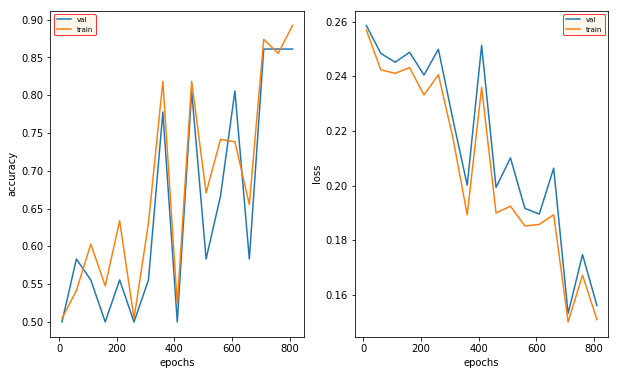

In [48]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 6))

ax[0].plot(steps, test_acc, label = 'val')
ax[0].plot(steps, train_acc, label = 'train')
ax[0].legend(fontsize=7, ncol=1, facecolor='oldlace', edgecolor='r')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('accuracy')


ax[1].plot(steps, test_loss, label = 'val')
ax[1].plot(steps, train_loss, label = 'train')
ax[1].legend(fontsize=7, ncol=1, facecolor='oldlace', edgecolor='r')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('loss')

plt.show()